# Machine Learning Portfolio 2

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
    - [Timeseries Feature Engineering](#time-series-feature-engineering)
        - [Invloed van bestaande en nieuwe Features](#invloed-van-bestaande-en-nieuwe-features)
        - [Features kiezen](#features-kiezen)
- [Modeling](#modeling)
    - [K-Nearest Neighbors Regression](#k-nearest-neighbors-regression)
    - [Linear Regression](#linear-regression)
    - [Decision Tree Regressor](#decision-tree-regressor)
    - [Support Vector Regression](#support-vector-regression)
    - [Ensembles](#ensembles)
        - [Random Forest Regressor](#random-forest-regressor)
        - [Gradient Boost](#gradient-boost)
        - [XGBoost](#xgboost)
        - [AdaBoost](#adaboost)
        - [Stacking](#stacking)
    - [Timeseries models](#timeseries-models)
        - [SARIMAX](#sarimax)
        - [Prophet](#prophet)
    - [Hybrid model](#hybrid-model)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [2]:
# Libraries

import os
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet


from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

## Data Overview

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [3]:
train = pd.read_csv('train.csv', parse_dates=['date_hour'], index_col='date_hour')
test = pd.read_csv('test.csv', parse_dates=['date_hour'], index_col='date_hour')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
# Train and Test data
display(train.head(10), test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,1
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,3
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,8


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343


In [5]:
# Sample submission for kaggle
display(sample_submission.head(10))

,date_hour,cnt
0,2012-12-01 00:00:00,784
1,2012-12-01 01:00:00,80
2,2012-12-01 02:00:00,605
3,2012-12-01 03:00:00,604
4,2012-12-01 04:00:00,544
5,2012-12-01 05:00:00,100
6,2012-12-01 06:00:00,344
7,2012-12-01 07:00:00,18
8,2012-12-01 08:00:00,57
9,2012-12-01 09:00:00,603


## Exploratory Data Analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.0 MB


#### Data Types:  

Er zijn verschillende data types aanwezig:
- **datetime**: date_hour
- **Integer**: holiday, weathersit en cnt
- **Float**: temp, atemp, hum en windspeed

In [7]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


#### Controle op Ontbrekende Waarden

In [8]:
print(train.isnull().sum())

holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

#### Vorm van de gegevens

In [9]:
print(train.shape)

(16637, 7)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

#### Kolommen beschrijven:  
- **date_hour**: Datum en tijdstip.
- **holiday**: Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit**: De beschrijving van de weersomstandigheden op een schaal van 1 tot 4, waarbij 1 goed weer is en 4 heel slecht weer.
- **temp**: Genormaliseerd temperatuur
- **atemp**: Genormaliseerd gevoelstemperatuur
- **hum**: Genormaliseerd luchtvochtigheid
- **windspeed**: Genormaliseerd windsnelheid
- **cnt**: Aantal verhuurd

#### Het meetniveau voor elke kolom:  
- **date_hour**: Interval
- **holiday**: Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit**: Ordinaal (categorieën hebben een volgorde).
- **temp**: Interval (continue variabele).
- **atemp**: Interval (continue variabele).
- **hum**: Interval (continue variabele).
- **windspeed**: Interval (continue variabele).
- **cnt**: Ratio

In [10]:
def resample_datetime(df):
    """
    Resample a DataFrame's datetime index into additional time-related features.

    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with a DatetimeIndex. The index should contain datetime-like objects.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the original data, and additional columns for year, month,
        week of the year, day of the year, day of the month, day of the week, and hour.
    """

    data = df.copy()
    data["year"] = data.index.year
    data["month"] = data.index.month
    data["week_of_year"] = data.index.isocalendar().week
    data["day_of_year"] = data.index.day_of_year
    data["day_of_month"] = data.index.day
    data["day_of_week"] = data.index.weekday
    data["hour"] = data.index.hour
    return data

In [11]:
data = resample_datetime(train)
display(data)

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,52,1,1,5,0
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,52,1,1,5,1
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,52,1,1,5,2
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,52,1,1,5,3
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,52,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,48,335,30,4,19
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,48,335,30,4,20
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,48,335,30,4,21


### Visualiseren

In [12]:
class DataVisualizer:
    """
    A class for visualizing various aspects of a pandas DataFrame with datetime index.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        A DataFrame with a DatetimeIndex. The index should contain datetime-like objects.

    Attributes
    ----------
    df : pandas.DataFrame
        A copy of the input dataframe.

    Methods
    -------
    plot_time_series(value_col, year=None, title="Time Series Analysis", xlabel="Time", ylabel="Value"):
        Plots a time series for a specific column, optionally filtered by year.

    plot_distributions(continuous_cols, bins=30):
        Plots the distribution of continuous variables as histograms with KDE.

    plot_categorical_counts(categorical_cols):
        Plots the distribution of categorical variables as count plots.

    plot_boxplots(cols, title="Boxplots for Outliers"):
        Plots boxplots for a list of continuous columns to identify outliers.

    plot_time_components_vs_cnt(time_components, target_col='cnt', title="Time Components vs. Target"):
        Plots the relationship between time components (e.g., year, month) and a target variable.

    plot_boxplot(x_col, y_col, title=None, xlabel=None, ylabel=None):
        Plots a boxplot for a categorical variable vs a continuous variable.

    plot_correlation_matrix(cols, title="Correlation Matrix"):
        Plots a heatmap of the correlation matrix for the given columns.

    Raises
    ------
    ValueError
        If the dataframe does not have a DatetimeIndex.
    """

    def __init__(self, dataframe):
        """
        Initializes the DataVisualizer class with a pandas DataFrame.

        Parameters
        ----------
        dataframe : pandas.DataFrame
            A DataFrame with a DatetimeIndex. The index should contain datetime-like objects.

        Raises
        ------
        ValueError
            If the DataFrame does not have a DatetimeIndex.
        """
        # Ensure the dataframe has a datetime index
        if not isinstance(dataframe.index, pd.DatetimeIndex):
            raise ValueError("The dataframe index must be a DatetimeIndex.")
        self.df = dataframe.copy()
        sns.set_style("darkgrid")

    def plot_time_series(
        self,
        value_col,
        year=None,
        title="Time Series Analysis",
        xlabel="Time",
        ylabel="Value",
    ):
        """
        Plots a time series for a specific column, optionally filtered by year.

        Parameters
        ----------
        value_col : str
            The column of the DataFrame to plot on the y-axis.

        year : int, optional
            The year to filter the data. If None, the plot will show the entire time series.

        title : str, optional
            The title of the plot. Default is "Time Series Analysis".

        xlabel : str, optional
            The label for the x-axis. Default is "Time".

        ylabel : str, optional
            The label for the y-axis. Default is "Value".
        """
        data_to_plot = self.df
        if year is not None:
            data_to_plot = data_to_plot[data_to_plot.index.year == year]
            title += f" ({year})"

        plt.figure(figsize=(14, 6))
        plt.plot(data_to_plot.index, data_to_plot[value_col])
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_distributions(self, continuous_cols, bins=30):
        """
        Plots the distribution of continuous variables as histograms with KDE.

        Parameters
        ----------
        continuous_cols : list of str
            A list of column names in the DataFrame that contain continuous variables to plot.

        bins : int, optional
            The number of bins for the histograms. Default is 30.
        """

        n_cols = 2
        n_rows = (len(continuous_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Continuous Variables", fontsize=16)
        axes = axes.flatten()

        for i, col in enumerate(continuous_cols):
            sns.histplot(self.df[col], bins=bins, kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")

        for j in range(len(continuous_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_categorical_counts(self, categorical_cols):
        """
        Plots the distribution of categorical variables as count plots.

        Parameters
        ----------
        categorical_cols : list of str
            A list of column names in the DataFrame that contain categorical variables to plot.
        """
        n_cols = 2
        n_rows = (len(categorical_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Categorical Variables", fontsize=16)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols):
            sns.countplot(x=self.df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")

        for j in range(len(categorical_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplots(self, cols, title="Boxplots for Outliers"):
        """
        Plots boxplots for detecting outliers in the specified columns.

        Parameters
        ----------
        cols : list of str
            A list of column names in the DataFrame for which to create boxplots.

        title : str, optional
            The title of the plot. Default is "Boxplots for Outliers".
        """
        fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 6))
        fig.suptitle(title, fontsize=16)

        for i, col in enumerate(cols):
            sns.boxplot(y=self.df[col], ax=axes[i])
            axes[i].set_title(col)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_time_components_vs_cnt(
        self, time_components, target_col="cnt", title="Time Components vs. Target"
    ):
        """
        Plots line plots for time components against a target variable.

        Parameters
        ----------
        time_components : list of str
            A list of column names or time-related components (e.g., 'year', 'month', 'day') to plot
            on the x-axis.

        target_col : str, optional
            The column to plot on the y-axis (the target variable). Default is 'cnt'.

        title : str, optional
            The title of the plot. Default is "Time Components vs. Target".
        """
        n_cols = 2
        n_rows = (len(time_components) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle(title, fontsize=16)
        axes = axes.flatten()

        for i, component in enumerate(time_components):
            sns.lineplot(x=component, y=target_col, data=self.df, ax=axes[i])
            axes[i].set_title(f"{component} vs. {target_col}")

        for j in range(len(time_components), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplot(self, x_col, y_col, title=None, xlabel=None, ylabel=None):
        """
        Plots a boxplot to visualize the distribution of a target variable by a categorical feature.

        Parameters
        ----------
        x_col : str
            The column name in the DataFrame to be used as the categorical variable on the x-axis.

        y_col : str
            The column name in the DataFrame to be used as the target variable on the y-axis.

        title : str, optional
            The title of the plot. If None, a default title will be used. Default is None.

        xlabel : str, optional
            The label for the x-axis. If None, the name of `x_col` will be used as the label. Default is None.

        ylabel : str, optional
            The label for the y-axis. If None, the name of `y_col` will be used as the label. Default is None.
        """
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=self.df[x_col], y=self.df[y_col])
        plt.title(title if title else f"Boxplot of '{y_col}' by '{x_col}'")
        plt.xlabel(xlabel if xlabel else x_col)
        plt.ylabel(ylabel if ylabel else y_col)
        plt.show()

    def plot_scatter(self, cols, target='cnt', title='Scatter plot between features and target'):
        """
        Make scatter plots of the columns in 'cols' vs the target 'cnt'.

        Parameters
        ----------
        cols : list of str
            A list of column names to plot.
        target : str
            The target to plot with the cols.
        title : str
            Title of the plots.
        """
        fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 6))
        fig.suptitle(title, fontsize=16)

        for i, col in enumerate(cols):
            sns.scatterplot(data=self.df, x=col, y=target, ax=axes[i])
            axes[i].set_title(col)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_correlation_matrix(self, cols, title="Correlation Matrix"):
        """
        Plots a heatmap of the correlation matrix for the specified columns.

        Parameters
        ----------
        cols : list of str
            A list of column names for which to calculate and plot the correlation matrix.

        title : str, optional
            The title of the plot. Default is "Correlation Matrix".
        """
        plt.figure(figsize=(10, 8))
        correlation_matrix = self.df[cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(title)
        plt.show()


# Initialize the visualizer with your dataframe
visualizer = DataVisualizer(data)

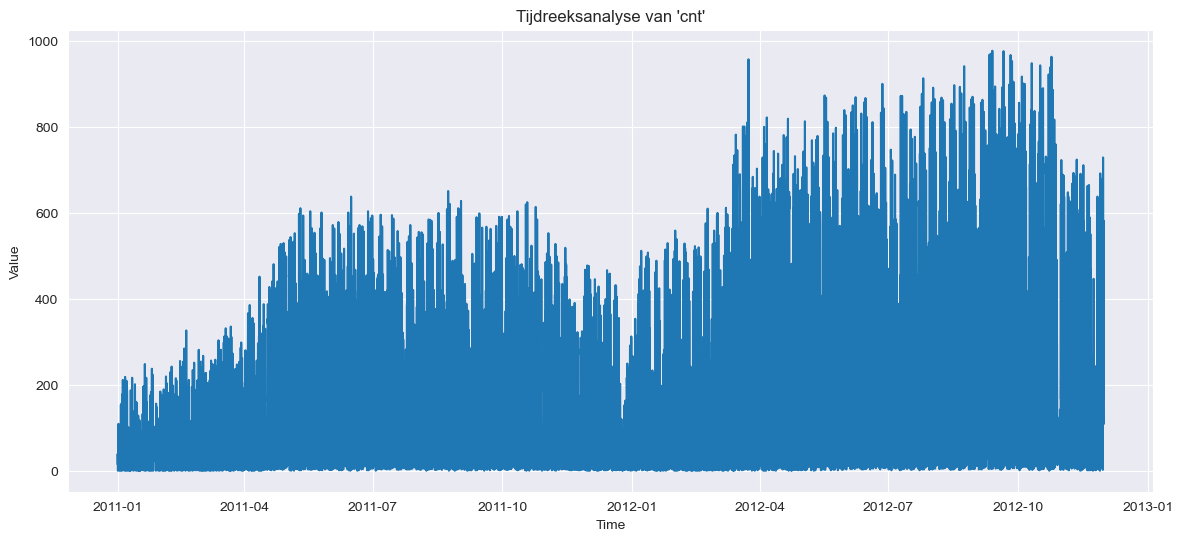

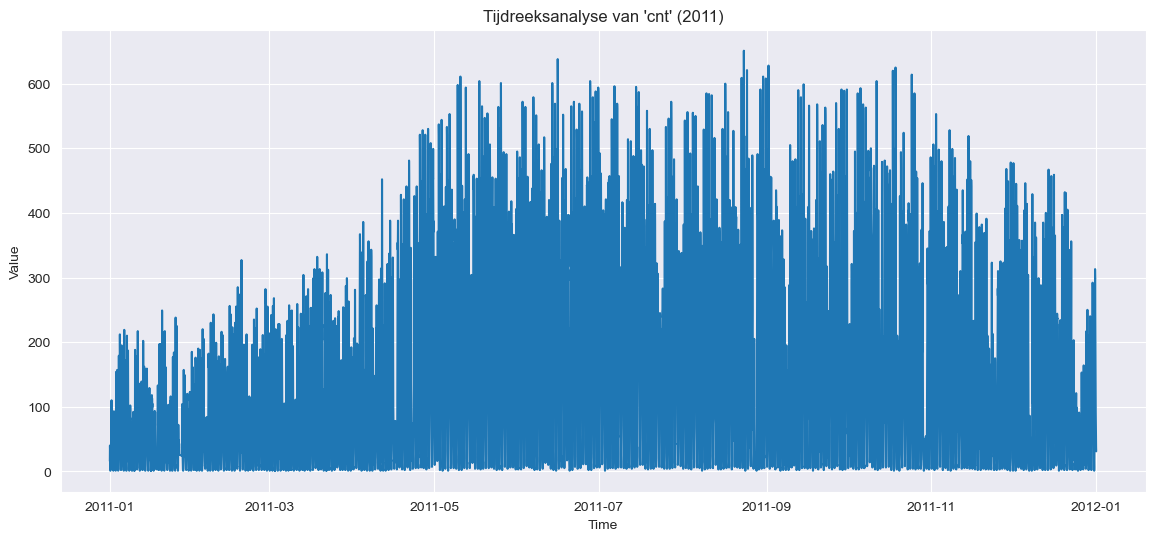

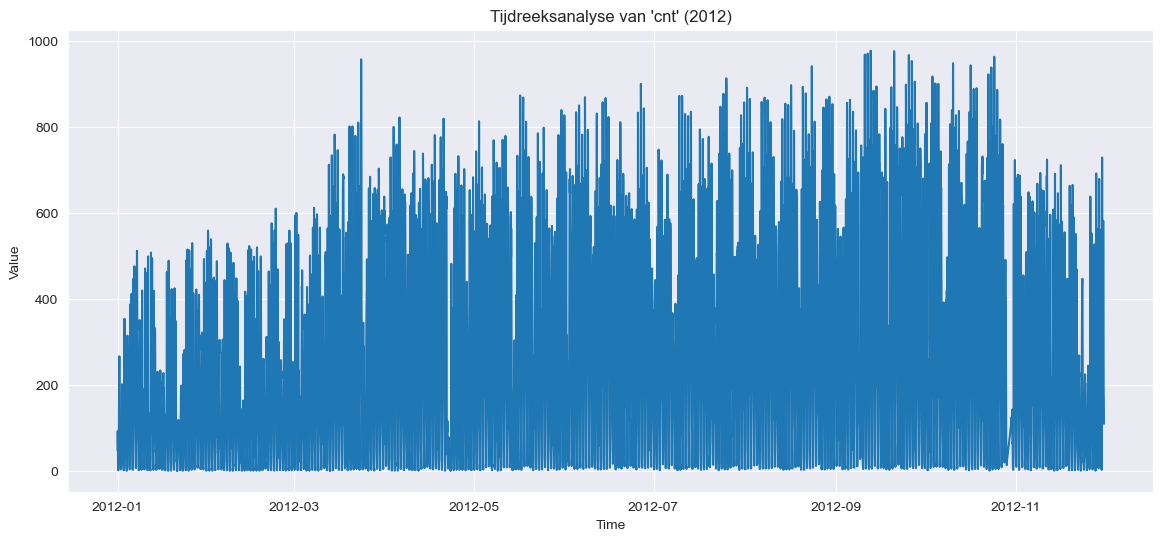

In [13]:
visualizer.plot_time_series(value_col='cnt', title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2011, title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2012, title="Tijdreeksanalyse van 'cnt'")

### Verdeling van de kolommen

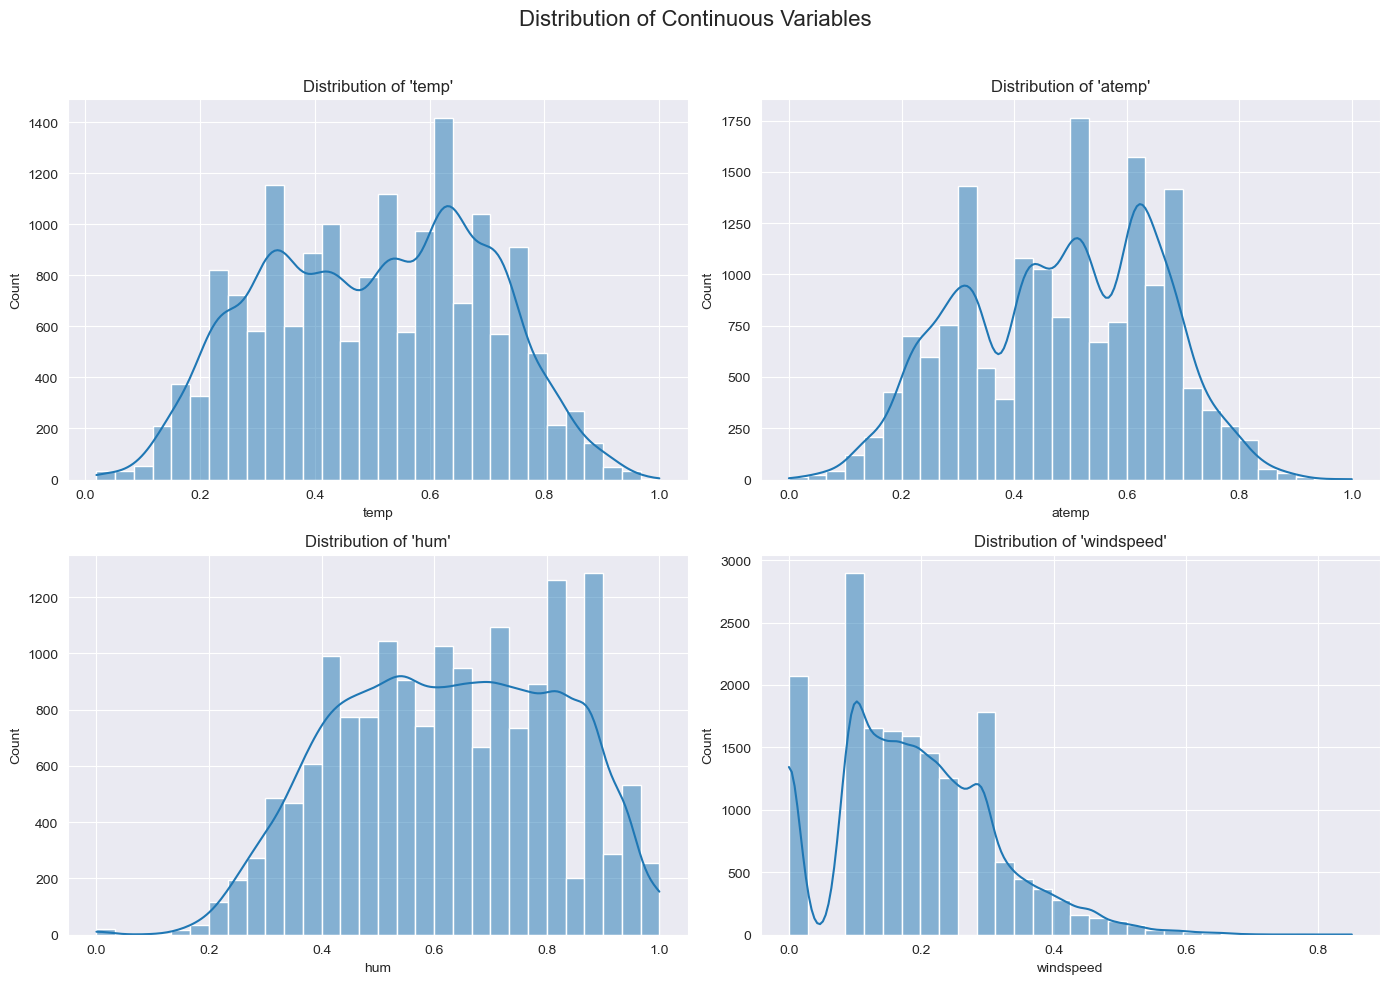

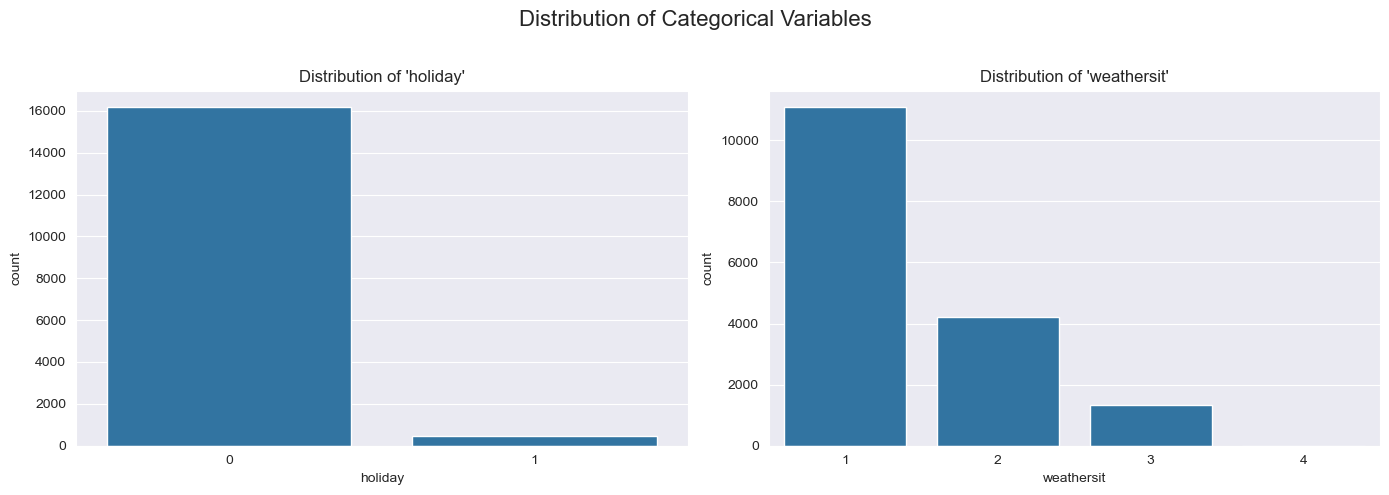

In [14]:
visualizer.plot_distributions(continuous_cols=['temp', 'atemp', 'hum', 'windspeed'])
visualizer.plot_categorical_counts(categorical_cols=['holiday', 'weathersit'])

### Relaties

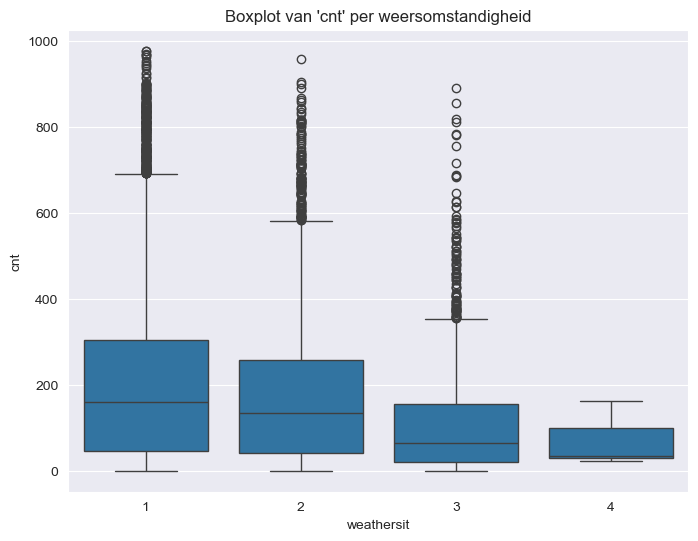

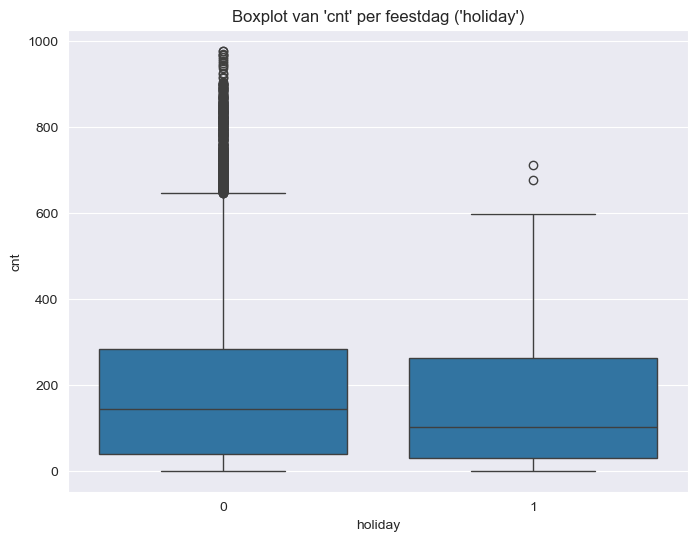

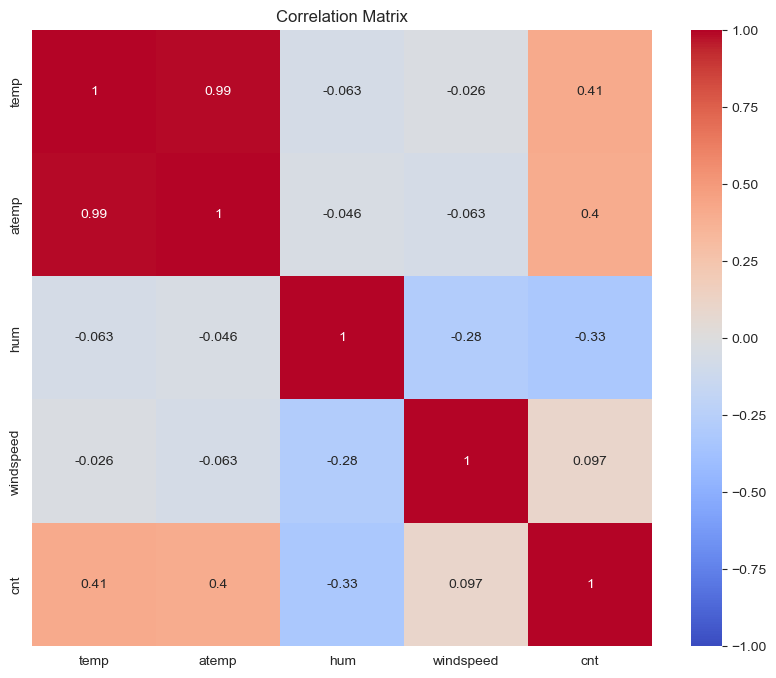

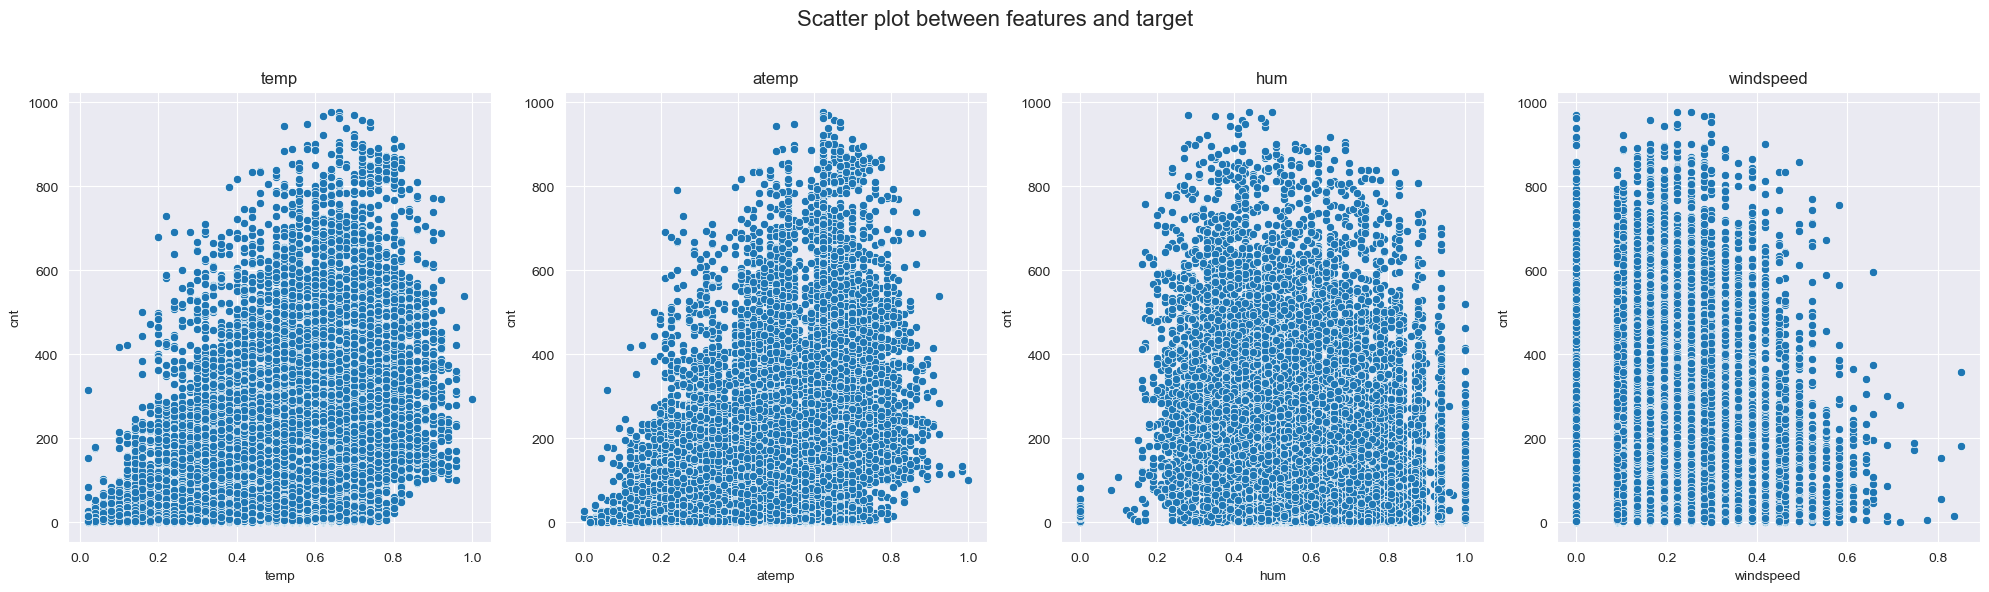

In [15]:
visualizer.plot_boxplot(x_col='weathersit', y_col='cnt', title="Boxplot van 'cnt' per weersomstandigheid")
visualizer.plot_boxplot(x_col='holiday', y_col='cnt', title="Boxplot van 'cnt' per feestdag ('holiday')")
visualizer.plot_correlation_matrix(cols=['temp', 'atemp', 'hum', 'windspeed', 'cnt'])
visualizer.plot_scatter(cols=['temp','atemp','hum','windspeed'])

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.
- Er blijkt heel weinig holidays te zijn
- De verdeling bij weeromstaandigheid is er te zien dat de aantallen per waarde daalt, waarbij 1 de hoogste is. 

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.

**Scatterplots**

- Er zijn geen vaste relaties te vinden tussen de features (temp, atemp, hum en winspeed) en target (cnt).

#### Controle op Uitschieters

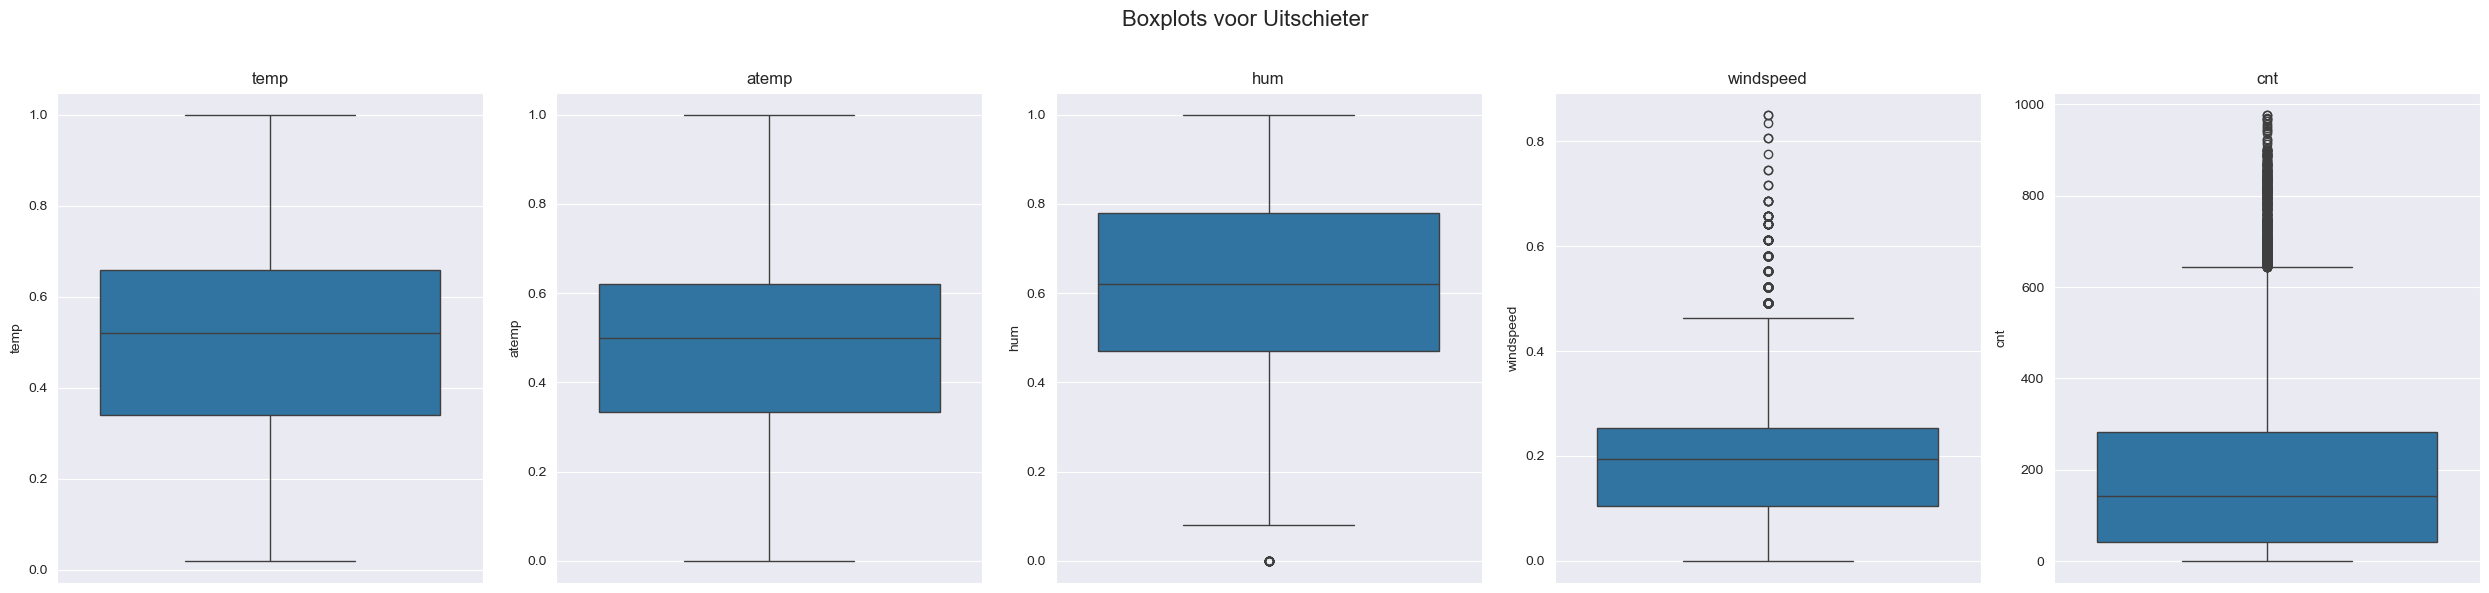

In [16]:
# Boxplots for outliers
visualizer.plot_boxplots(cols=["temp", "atemp", "hum", "windspeed", "cnt"], 
                         title="Boxplots voor Uitschieter")

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.


De outliers zullen niet worden verwijderd, omdat deze waarden veel invloed kunnen hebben op onze modellen. Het is een tijdreeksdataset, wat betekent dat de data veel schommelingen kan vertonen. Daarom is het juist nuttig om de outliers in onze tijdreeksmodellen te gebruiken, aangezien deze schommelingen een belangrijk kenmerk van de data kunnen zijn.

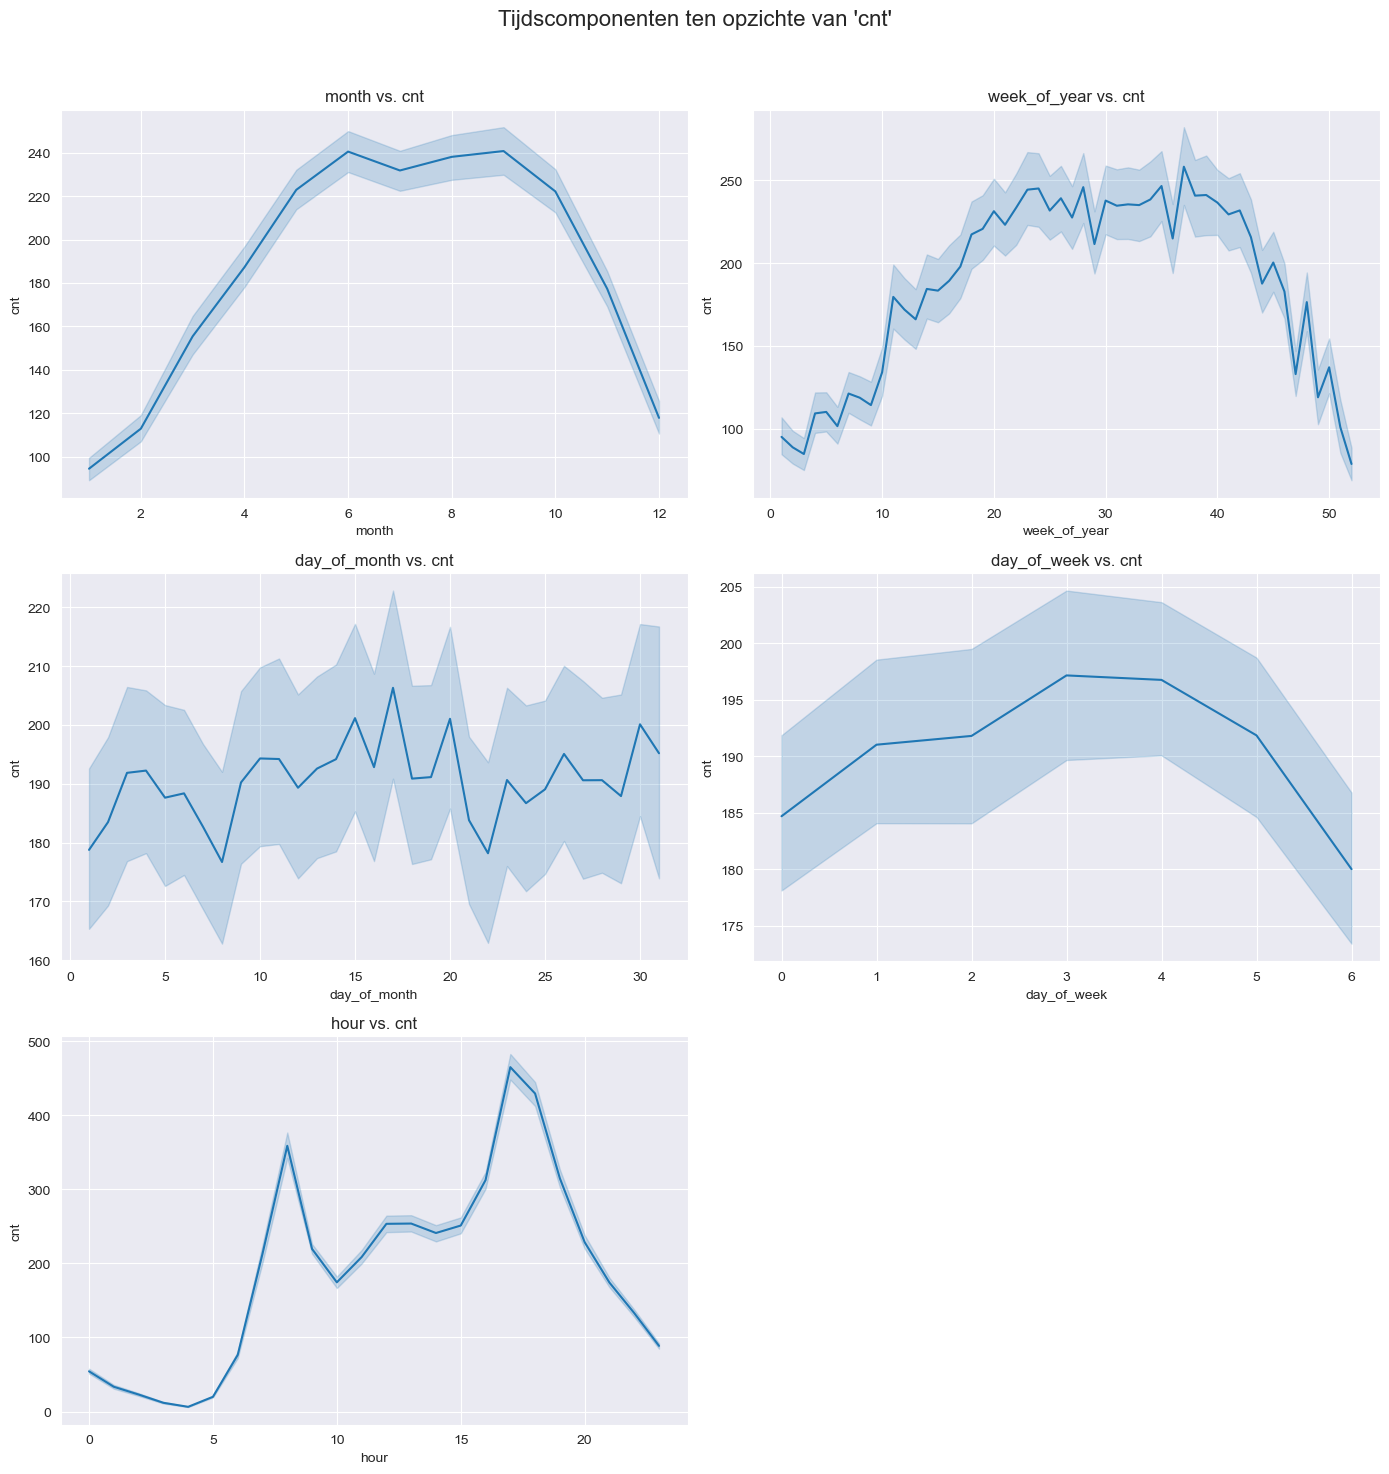

In [17]:
# Time components vs 'cnt'
visualizer.plot_time_components_vs_cnt(time_components=['month', 'week_of_year', 'day_of_month','day_of_week', 'hour'],
                                        target_col="cnt", 
                                        title="Tijdscomponenten ten opzichte van 'cnt'")

Uit de plots hierboven zien we dat het product meer verhuurd wordt in bepaalde seizoen en tijden van de dag. We zien dat de piek in de zomer en begin herfst ligt. Door de week is er geen grote verschillen in het aantal verhuurd, maar het hoogste gemiddelde zit in donderdag(3) en vrijdag(4). En het laagste is op de zondag(6). Bij hour vs cnt zien we dat er tijdens de piek uren meer wordt verhuurd.

## Feature Engineering

### Analysis

In [79]:
class time_series_analysis:
    """
    A class for performing time series analysis on a DataFrame with a DatetimeIndex.

    This class provides methods for various time series analyses, including:
    - Plotting the periodigram (frequency domain analysis)
    - Plotting autocorrelation and partial autocorrelation functions
    - Decomposing a time series into trend, seasonal, and residual components

    Parameters
    ----------
    dataframe : pandas.DataFrame
        A DataFrame with a DatetimeIndex containing the time series data.

    Attributes
    ----------
    df : pandas.DataFrame
        The input DataFrame with time series data.
    """

    def __init__(self, dataframe):
        """
        Initializes the time_series_analysis class with a DataFrame.

        Parameters
        ----------
        dataframe : pandas.DataFrame
            A DataFrame with time series data, where the index is of type DatetimeIndex.
        """
        self.df = dataframe

    def periodigram(self, col="cnt", xlim=None, ylim=None, filter_amp=None):
        """
        Plots the periodigram (frequency spectrum) of a specified column in the time series.

        Parameters
        ----------
        col : str, optional, default='cnt'
            The column name in the DataFrame for which to compute the periodigram.

        xlim : tuple of float, optional
            The limits for the x-axis (frequency range). If None, the full range is used.

        ylim : tuple of float, optional
            The limits for the y-axis (amplitude range). If None, the full range is used.

        filter_amp : float, optional
            A threshold for filtering frequencies based on amplitude. Frequencies with
            amplitude less than this value are excluded from the output. If None, no filtering is applied.
        """
        timeserie = self.df[col]
        n = len(timeserie)
        freq = np.fft.fftfreq(n, 1)
        fft_result = fft(timeserie)

        plt.figure(figsize=(10, 6))
        plt.plot(freq, np.abs(fft_result))
        plt.xlabel("Frequency (1/hour)")
        plt.ylabel("Amplitude")
        if xlim != None:
            plt.xlim([0, 0.1])
        if ylim != None:
            plt.ylim([0, 1e6])
        plt.title("Periodigram")
        plt.grid(True)
        plt.show()

        df_fft = pd.DataFrame(np.abs(fft_result))
        df_fft["freq"] = freq
        hours = []
        days = []
        for f in freq:
            if f != 0:
                hours.append(1 / f)
                days.append(1 / f / 24)
            else:
                hours.append(np.inf)
                days.append(np.inf)
        df_fft["duur in uren"] = hours
        df_fft["duur in dagen"] = days
        df_fft.rename(columns={0: "amplitude"}, inplace=True)
        if filter_amp != None:
            df_fft = df_fft[(df_fft["amplitude"] > filter_amp) & (df_fft["freq"] > 0)]
        else:
            df_fft = df_fft[df_fft["freq"] > 0]
        display(df_fft)

    def plot_autocorrelations(self, col="", lags=24):
        """
        Plots the autocorrelation function (ACF) and partial autocorrelation function (PACF)
        for a specified column in the time series.

        Parameters
        ----------
        col : str
            The column name in the DataFrame for which to plot the autocorrelations.

        lags : int, optional, default=24
            The number of lags to include in the ACF and PACF plots.
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # ACF plot
        plot_acf(self.df[col], ax=axes[0], lags=lags)
        axes[0].set_title("Autocorrelation Function (ACF)")

        # PACF plot
        plot_pacf(self.df[col], ax=axes[1], lags=lags)
        axes[1].set_title("Partial Autocorrelation Function (PACF)")

        plt.tight_layout()
        plt.show()

    def plot_seasonal_decompose(self, col="", model="additive", period=24):
        """
        Plots the seasonal decomposition of a time series into trend, seasonal, and residual components.

        Parameters
        ----------
        col : str
            The column name in the DataFrame for which to perform the seasonal decomposition.

        model : {'additive', 'multiplicative'}, optional, default='additive'
            The model to use for decomposition. If 'additive', the time series is decomposed
            as: Y(t) = Trend(t) + Seasonal(t) + Residual(t). If 'multiplicative',
            the decomposition is: Y(t) = Trend(t) * Seasonal(t) * Residual(t).

        period : int, optional, default=24
            The number of observations per cycle. For example, if the time series has hourly data,
            and you expect a daily seasonal pattern, set `period=24`.
        """
        sd = seasonal_decompose(self.df[col], model=model, period=period)
        plt.figure(figsize=(30, 6))
        plt.title("Trend")
        sd.trend.plot()
        plt.figure(figsize=(30, 6))
        plt.title("Seasonal")
        sd.seasonal.plot()
        plt.figure(figsize=(30, 6))
        plt.title("Resid")
        sd.resid.plot()
        plt.show()


ts_analyzer = time_series_analysis(train)

#### Seizoenspatronen met Fourier analyse

##### Wat is Fourier analyse?
Het is een wiskundig methode dat patronen vindt binnen een genormaliseerde timeseries dataset. Het vereenvoudigt complexe data door het te veranderen naar een serie van trigonomische of exponentiele functies. Door alle complicerende factors van het dataset weg te halen kunnen patronen makkelijker herkend worden, waardoor voorspellingen maken makkelijker wordt.

[(Hayes, 2023)](https://www.investopedia.com/terms/f/fourieranalysis.asp) 

De formule van een Fourier series:
$$
f(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty}(a_k\cos(2\pi kt) + b_k\sin(2\pi kt))
$$

waar
- $\frac{a_0}{2}$ het constante term representeert,
- $a_k\cos(2\pi kt)$ en $b_k\sin(2\pi kt)$ de cosinus en sinus termen zijn,
- $k$ het harmonische frequentie is,
- $\sum_{k=1}^{\infty}$ zegt dat er een oneindig serie van sinus en cosinus functies met verschillende frequenties en amplitudes opgeteld worden, die $f(t)$ preciezer zou vinden

Een fourier analyse is het manier waarop functies benaderd kunnen worden door het combinatie van trigonometrische functies. 

[(3Blue1Brown, 2018)](https://www.youtube.com/watch?v=spUNpyF58BY )


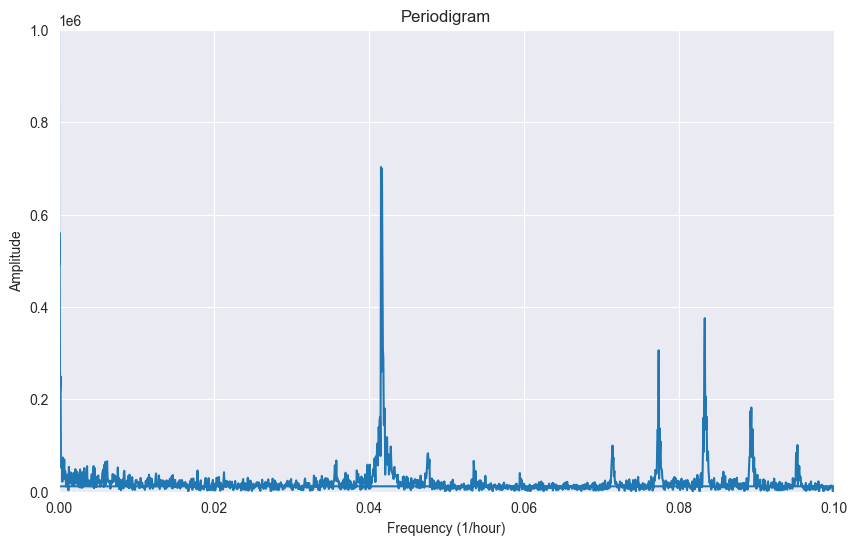

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422
696,307463.826990,0.041834,23.903736,0.995989
1288,306064.251401,0.077418,12.916925,0.538205
1387,375575.609672,0.083368,11.994953,0.499790


In [80]:
ts_analyzer.periodigram(xlim=[0,0.1], ylim=[0,1e6], filter_amp=0.3e+06)

Dit periodogram toont de verdeling van de amplitude van signalen over verschillende frequenties met betrekking tot het aantal verhuurde. De x-as geeft de frequentie weer in eenheden van "1/uur", waarbij een piek bij 0,04 1/uur betekent dat het patroon zich elke 24 uur herhaalt. De y-as toont de amplitude, waarbij hogere waarden duiden op een grotere invloed van die specifieke frequentie op het totaal aantal verhuurde. Grote pieken, zoals die rond 0,04 1/uur, wijzen op een sterk terugkerend patroon, wat kan duiden op dagelijkse fluctuaties in het aantal verhuurde. Andere pieken bij hogere frequenties kunnen wijzen op kortere cycli of variaties in de verhuuractiviteiten.

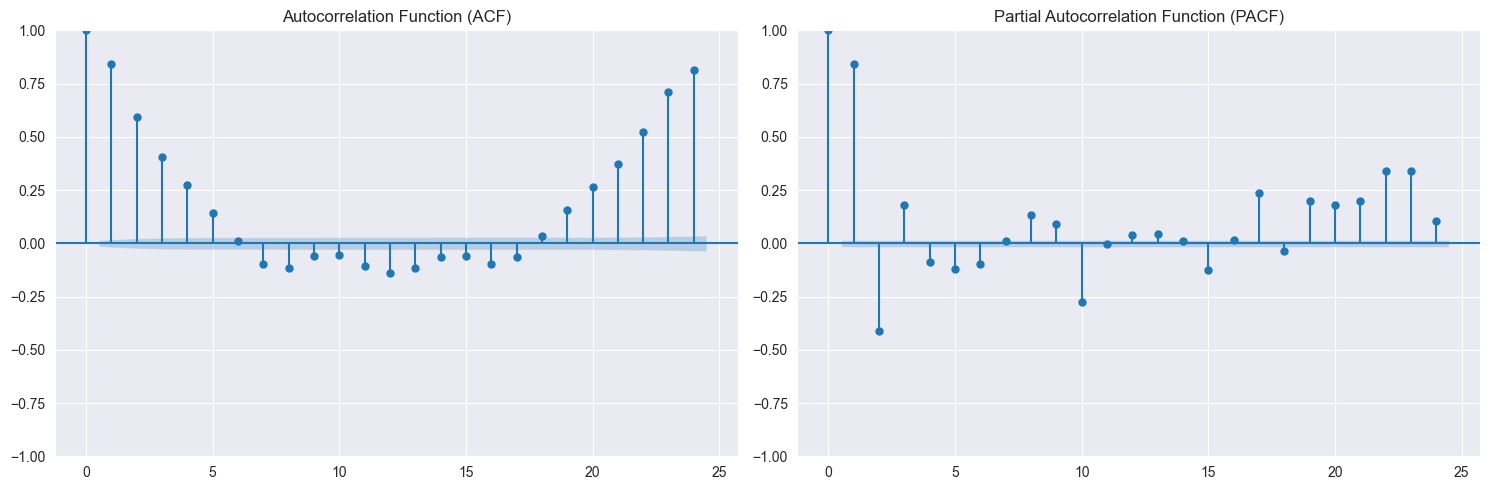

In [84]:
ts_analyzer.plot_autocorrelations(col='cnt', lags=24)

ACF (cnt):  
In het eerste uur (lag 1) is de correlatie hoog, wat betekent dat de gebeurtenissen van 1 uur geleden sterk verband houden met het huidige uur. Daarna neemt de correlatie af, omdat mensen minder vaak op korte termijn huren, maar rond het 24e uur begint deze weer te stijgen. Dit laat zien dat er een dagelijks patroon is. Het aantal cnt dat op een bepaald tijdstip wordt verhuurd, lijkt sterk op het aantal van 24 uur eerder, op hetzelfde tijdstip gisteren. Dit wijst op een herhalend patroon in de data.

PACF (cnt):  
De eerste lag  is hoog, wat betekent dat wat er één uur geleden gebeurde, veel invloed heeft op het aantal  cnt nu. De volgende lags zijn minder belangrijk, omdat de meeste informatie al door lag 1 wordt gegeven.

In de visualisaties is het te zien dat de target variabele begint toe te nemen rond april, en afneemt rond de wintermaanden, beginnend met november.

Trend Berekenen  
De trend in een tijdreeks toont de algemene richting van de data over een langere periode. Dit kan een stijgende of dalende lijn zijn, of een complexer patroon. Om de trend te berekenen, worden technieken gebruikt zoals het moving Average of exponentiële smoothing, die helpen om tijdelijke fluctuaties te verminderen, zodat de langetermijnbeweging beter zichtbaar wordt.

 Seizoen Berekenen  
De seizoensgebonden component in een tijdreeks bestaat uit patronen die regelmatig terugkeren, bijvoorbeeld elk jaar of elk kwartaal. Om de seizoensgebonden fluctuaties te berekenen, wordt de tijdreeks opgesplitst in drie delen: trend, seizoen en residu. Door de trend en het residu te verwijderen, blijven de seizoensgebonden veranderingen over. 

Residu Berekenen  
Het residu is het deel van de tijdreeks dat overblijft nadat de trend en het seizoen zijn weggelaten. Dit vertegenwoordigt de willekeurige fluctuaties die niet kunnen worden verklaard door de trend of het seizoen. Het residu wordt berekend door eerst de trend en het seizoen te verwijderen. Het resultaat zijn onverklaarbare variaties die moeilijk te voorspellen zijn en vaak als ruis worden gezien.  
[(Venujkvenk, 2023)](https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1)

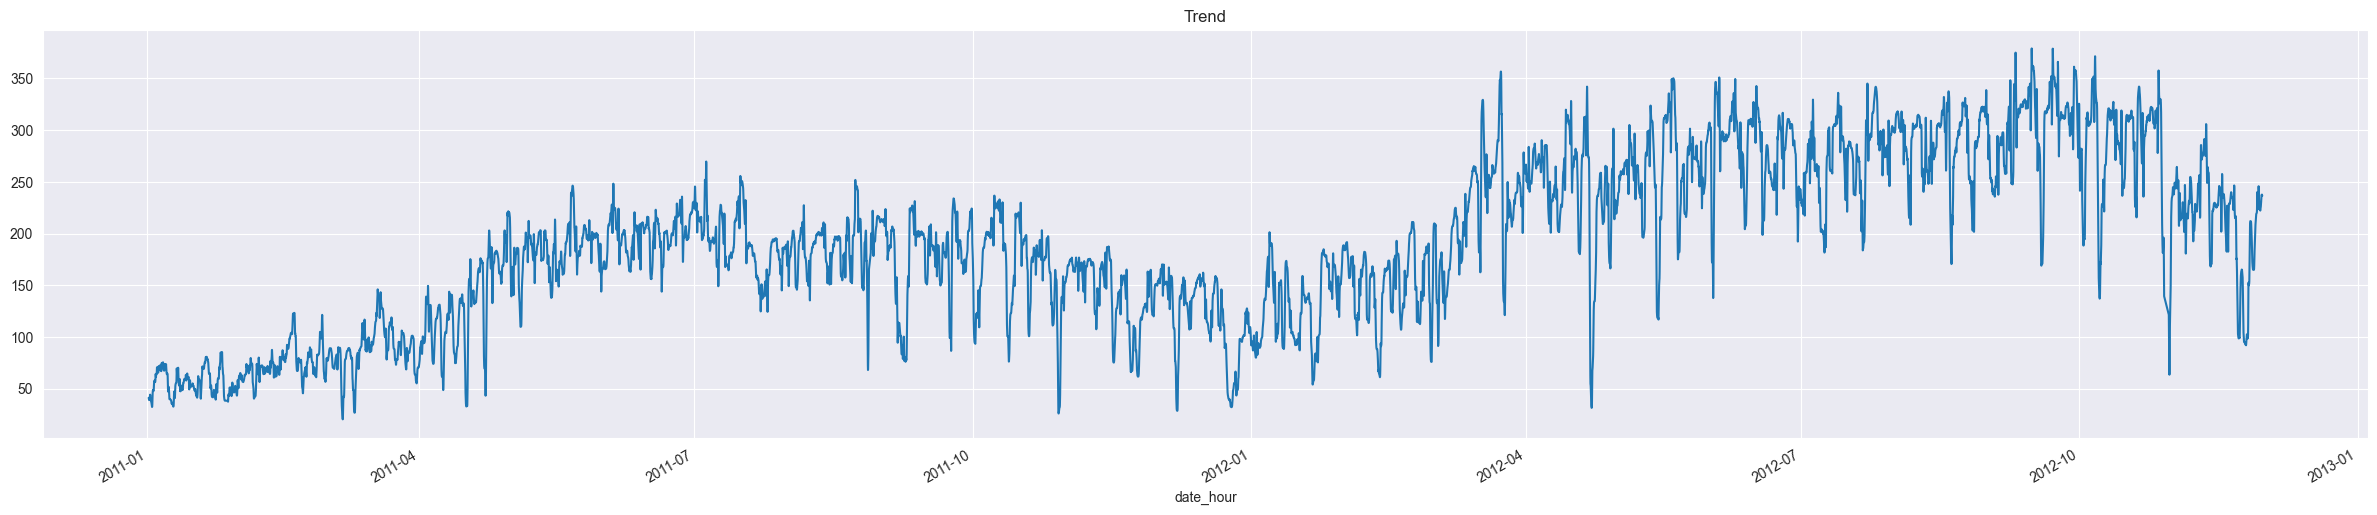

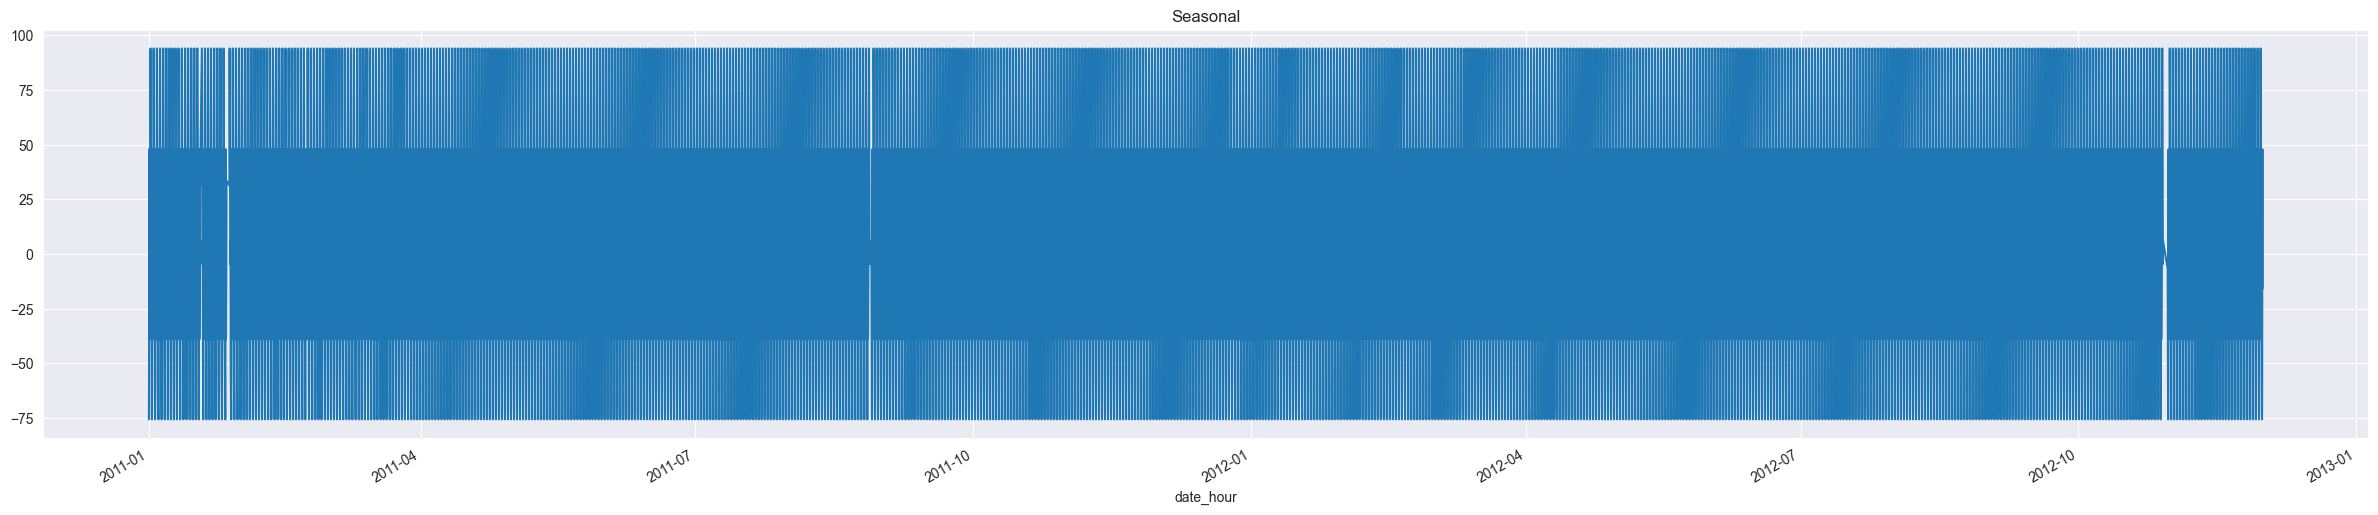

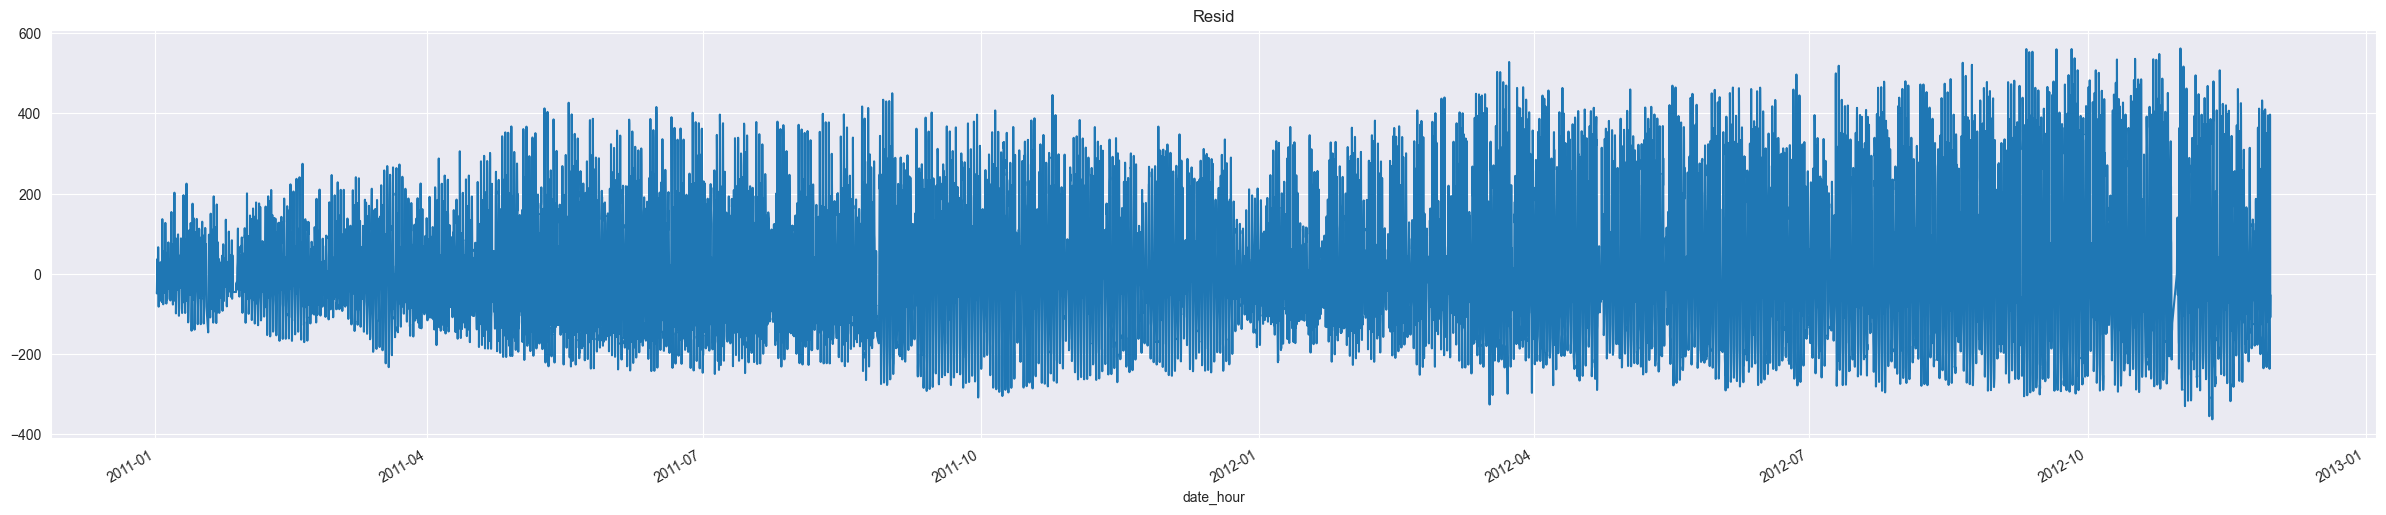

In [85]:
ts_analyzer.plot_seasonal_decompose(col='cnt', model='additive', period=24)

Trend:  
Dit laat de algemene trend over een langere periode zien. Er is een stijging in het aantal cnt. Als men naar de grafiek kijkt, ziet men dat het aantal verhuringen meestal toeneemt van 2011 tot de zomer van 2012, maar daarna schommelt het wat. Daarna stijgt het weer.

Seizoen:  
Dit  laat zien hoe het aantal cnt elke dag of week hetzelfde is. Men ziet pieken en dalen die waarschijnlijk te maken hebben met vaste patronen, zoals drukke uren (ochtend- en avondspits) en rustige uren (zoals 's nachts). Het is duidelijk dat er op een dag altijd pieken zijn.

Resid:  
Dit is de ruis of onvoorspelbare dingen die kunnen gebeuren. Deze grafiek toont die onregelmatigheden, maar we kunnen er niet veel uit halen, omdat de meeste informatie al uit de trend en seizoensgebonden patronen is gehaald. Het biedt weinig nieuwe inzichten, omdat de grotere patronen al duidelijk zijn.

Onderzoek naar trends

Na een Fourier analyse uit te voeren op de data, is het te zien dat de grootste trends jaarlijks en dagelijks zijn. De jaarlijkse trends zou in dit geval groei van het populariteit van het product over tijd kunnen zijn, dit ligt aan het feit dat de jaarlijkse piek in 2011 lager is dan die van 2012.

De dagelijkse trend kan liggen aan andere variabelen, zoals temperatuur, weeromstandigheden of vakantie.

### Time Series Feature Engineering

#### Invloed van bestaande en nieuwe features

We hebben een klasse genaamd RegressieModellenTester gemaakt om de modellen snel te testen. Dit helpt bij het selecteren van de beste features voor het model.

In [18]:
class RegressieModellenTester:
    def __init__(self, data, target_column, features=None):
        """
        Initialiseer de tester voor regressiemodellen.

        :param data: De dataset (pandas DataFrame).
        :param target_column: De naam van de doelkolom.
        :param features: Lijst van features (kolomnamen) om te gebruiken voor modeltraining.
                         Als None, worden alle kolommen behalve de doelkolom gebruikt.
        """
        self.data = data.copy()
        self.target_column = target_column

        # Controleer of target_column bestaat
        if self.target_column not in self.data.columns:
            raise ValueError(
                f"De opgegeven target kolom '{self.target_column}' bestaat niet in de DataFrame."
            )

        # Als geen specifieke features worden opgegeven, gebruik dan alle kolommen behalve de target
        if features is None:
            self.features = self.data.drop(columns=[self.target_column]).columns
        else:
            # Controleer of alle opgegeven features bestaan in de dataset
            missing_features = [col for col in features if col not in self.data.columns]
            if missing_features:
                raise ValueError(
                    f"De volgende features ontbreken in de DataFrame: {', '.join(missing_features)}"
                )
            self.features = features

        # Train-test splitsen
        self.X = self.data[self.features]
        self.y = self.data[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, shuffle=True
        )

        # Modellen initialiseren
        self.models = {
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(),
            "AdaBoost": AdaBoostRegressor(),
            "Decision Tree": DecisionTreeRegressor(),
            "KNN Regression": KNeighborsRegressor(),
            "XGBoost": xgb.XGBRegressor(),
            "SVR": SVR()

        }
        

    def train_and_evaluate(self):
        """
        Train en evalueer de modellen, en retourneer de resultaten in een DataFrame.

        :return: Pandas DataFrame met de resultaten van elk model.
        """
        results = []

        for model_name, model in self.models.items():
            # Model trainen
            model.fit(self.X_train, self.y_train)

            # Voorspellingen maken
            y_pred = model.predict(self.X_test)

            # RMSE berekenen
            rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))

            # Resultaten opslaan
            results.append({"Model": model_name, "RMSE": rmse})

        # Resultaten teruggeven als DataFrame
        return pd.DataFrame(results)

Hieronder hebben wij alle features gebruikt, maar de score bleken niet goed te zijn.

In [ ]:
tester_1 = RegressieModellenTester(train, "cnt", features=None)
resultaten_1 = tester_1.train_and_evaluate()
print(resultaten_1)

               Model        RMSE
0  Linear Regression  153.136946
1      Random Forest  161.658607
2           AdaBoost  159.440775
3      Decision Tree  187.689776
4     KNN Regression  156.958018
5            XGBoost  150.886521
6                SVR  157.331176


Daarom hebben wij besloten alleen de features te kiezen die sterk correleren met 'cnt'. Uit de EDA hebben we gezien dat weathersituation en temperatuur het meest correleren met 'cnt'.  
Hieronder zien we de features die het best correleren met cnt, maar leveren een slechtere score op dan alle features samen. 

In [ ]:
features = ["temp", "weathersit"]

tester_2 = RegressieModellenTester(train, "cnt", features=features)
resultaten_2 = tester_2.train_and_evaluate()
print(resultaten_2)

               Model        RMSE
0  Linear Regression  162.212568
1      Random Forest  160.937649
2           AdaBoost  170.755803
3      Decision Tree  160.952522
4     KNN Regression  171.374532
5            XGBoost  160.953705
6                SVR  165.886364


We hebben nu de volgende features toegevoegd: 'year', 'month', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week' en 'hour'.

In [ ]:
data = resample_datetime(train)
data_test = resample_datetime(test)

In [ ]:
tester_3 = RegressieModellenTester(data, "cnt", features=None)
resultaten_3 = tester_3.train_and_evaluate()
print(resultaten_3)

               Model        RMSE
0  Linear Regression  138.946236
1      Random Forest   40.733999
2           AdaBoost  107.213564
3      Decision Tree   54.869710
4     KNN Regression   73.374986
5            XGBoost   37.889759
6                SVR  182.551290


Als we terug kijken naar de EDA waar er visualisaties werden gemaakt van de verschillende tijdscomponenten, zien we dat deze tijdscomponenten invloed hebben op de 'cnt' kolom.  
Dus is er besloten om deze nieuwe tijdscomponenten ook te gebruiken als features en er blijkt een betere score te zijn.

In [ ]:
def get_season(month):
    """
    Retourneert het seizoen op basis van de maand.
    """
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"

def season(df):
    # Voeg een kwartaal kolom toe
    df["quarter"] = df.index.quarter

    # Voeg een seizoen kolom toe op basis van de maand
    df["season"] = df["month"].apply(get_season)

    # Voeg een dagnaam kolom toe
    df["day_name"] = df.index.day_name()

        # Zet de categorische variabelen om naar dummyvariabelen (one-hot encoding)
    df= pd.get_dummies(
        df,
        columns=["season", "day_name", "weathersit"],
        prefix=["season", "day_name", "weathersit"],
    )

    # Zet booleaanse kolommen om naar numerieke waarden (0 voor False, 1 voor True)
    boolean_columns = df.select_dtypes(include=["bool"]).columns
    for col in boolean_columns:
        df[col] = df[col].astype(int)



    return df


We hebben nu de volgende tijdsfeatures toegevoegd aan de dataset: de quarter kolom, die het kwartaal van het jaar aangeeft, de season kolom, die het seizoen (Winter, Spring, Summer, Autumn) bepaalt met aparte kolommen voor elk seizoen, en de day_name kolom, die de naam van de dag van de week toont met aparte kolommen voor elke dag. Daarnaast hebben we de weathersit kolom omgezet naar vier aparte kolommen, afhankelijk van de weersituatie. 

In [ ]:
data_s = season(data)
data_test_s = season(data_test)

In [ ]:
empty = [] +['cnt']
for x in data_s.columns:
    for i in  data_test_s.columns:
        if x == i:
            empty.append(x)
data_s = data_s[empty]

In [ ]:
tester_4 = RegressieModellenTester(data_s, "cnt", features=None)
resultaten_4 = tester_4.train_and_evaluate()
print(resultaten_4)

               Model        RMSE
0  Linear Regression  138.660724
1      Random Forest   40.840453
2           AdaBoost  105.838537
3      Decision Tree   54.178982
4     KNN Regression   77.016989
5            XGBoost   38.632378
6                SVR  182.584047


Hoewel we deze nieuwe features hebben toegevoegd, zien we nog geen groot verschil in de score van het model. Dus we gaan ervan uit dat deze nieuwe features niet zo een grote invloed hebben.

Wij hebben Fourier-termen als extra features toegevoegd, die helpen om seizoensgebonden patronen op verschillende frequenties te herkennen.

In [ ]:
# Volgens de analyse hebben we te maken met yearly en daily patronen
fourier1 = CalendarFourier(freq="YE", order=1)
fourier2 = CalendarFourier(freq="D", order=1)

dp = DeterministicProcess(
    index=data_s.index,
    constant=False,
    order=1,
    seasonal=False,
    additional_terms=[fourier1, fourier2],
    drop=True,
)

X_train2 = dp.in_sample()
test2 = dp.out_of_sample(steps=len(data_test_s), forecast_index=data_test_s.index)

data_f = pd.concat([data_s, X_train2], axis=1)
test_f = pd.concat([data_test_s, test2], axis=1)

In [ ]:
tester_5 = RegressieModellenTester(data_f, "cnt", features=None)
resultaten_5 = tester_5.train_and_evaluate()
print(resultaten_5)

               Model        RMSE
0  Linear Regression  122.968410
1      Random Forest   40.656216
2           AdaBoost  106.814399
3      Decision Tree   57.818596
4     KNN Regression  124.051771
5            XGBoost   37.790127
6                SVR  173.289521


We zien dat de score niet veel is veranderd

In [ ]:
# Stel dat je het beste model wilt gebruiken, bijvoorbeeld het model met de laagste RMSE
beste_model_naam = resultaten_5.loc[resultaten_5["RMSE"].idxmin(), "Model"]
beste_model = tester_5.models[beste_model_naam]

Hieronder zal er een feature importance grafiek gemaakt worden om een beter inzicht te krijgen welke nieuwe features het meeste invloed hebben.  
Hiermee kunnen we een koppeling maken met onze EDA en het iteratief proces waarbij er steeds nieuwe features werd toegevoegd. 

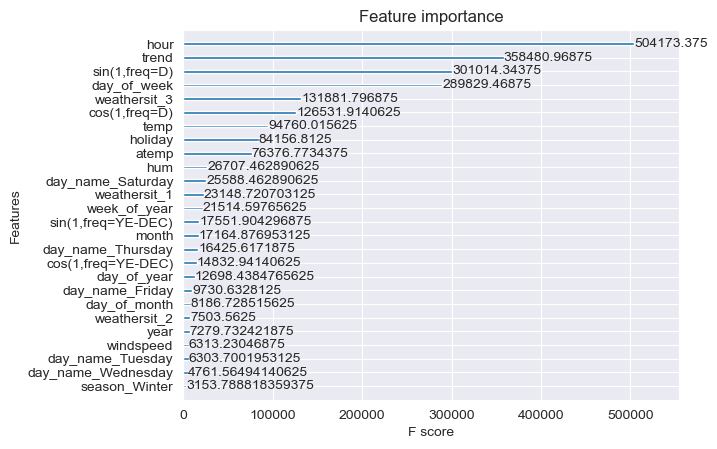

In [ ]:
plot_importance(beste_model, importance_type='gain')
plt.show()

Er is te zien dat 'hour' het meeste invloed heeft, maar ook 'day of the week', en dat klopt ook volgens onze EDA waarbij de tijdscomponenten werden gevisualiseerd. Aan de hand van het iteratief proces was er te zien dat de fourier features de scores niet echt veel had verbeterd, maar in deze grafiek zien we wel dat 'trend', 'sin' en 'cos' componenten invloed hebben op onze score.  
Verder zien wij ook dat 'weathersituation 3' ook invloed heeft op onze score en dat klopt ook met onze EDA. In de EDA werd de weathersituation ook gevisualiseerd met de 'cnt' kolom. 

#### Features kiezen

Uit de bevindingen van de bestaande en nieuwe features, hebben wij gekozen voor de tijdscomponenten zoals:  
- 'year', 'month', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week' en 'hour'. Omdat deze features de scores hebben verbeterd
- 'trend','sin(1,freq=YE-DEC)',	'cos(1,freq=YE-DEC)','sin(1,freq=D)','cos(1,freq=D)'. Omdat deze features uit de feature importance zijn gehaald
- 'weathersit_3'. Omdat deze feature uit de feature importance is gehaald en omdat het terugkoppelt op de EDA

In [37]:
class time_series_feature_engineering:
    """
    A class for performing feature engineering on time series data for both training and testing datasets.

    Parameters
    ----------
    train : pandas.DataFrame
        A DataFrame containing the training data, with a DatetimeIndex.

    test : pandas.DataFrame
        A DataFrame containing the test data, with a DatetimeIndex.

    target : str, optional, default=''
        The target column to separate from the features in the training dataset.

    Attributes
    ----------
    df : pandas.DataFrame
        The training dataset with the target column removed.
    X_train : pandas.DataFrame
        The feature set for training, including time-based features.
    y_train : pandas.Series
        The target column for training.
    test : pandas.DataFrame
        The test dataset with the same features as the training set.

    Methods
    -------
    get_season(month)
        Returns the season for a given month.

    check_missing_values(df, name)
        Checks for missing values in a DataFrame and prints a warning if any are found.

    add_fourier_feature(freqs, order, constant=False, seasonal=False, drop=True)
        Adds Fourier terms as features for the training and test datasets.

    lag_feature(column, lags)
        Creates lag features for the specified column in both the training and test datasets.
    """

    def __init__(self, train, test, target=""):
        """
        Initializes the time_series_feature_engineering class with training and test datasets.

        Parameters
        ----------
        train : pandas.DataFrame
            A DataFrame with the training data. The index must be a DatetimeIndex.

        test : pandas.DataFrame
            A DataFrame with the test data. The index must be a DatetimeIndex.

        target : str, optional, default=''
            The target column for the training dataset to separate from the features.

        Raises
        ------
        ValueError
            If the train or test DataFrames do not have a DatetimeIndex.
        """
        # Ensure the dataframe has a datetime index
        if not isinstance(train.index, pd.DatetimeIndex):
            raise ValueError("The train dataframe index must be a DatetimeIndex.")
        if not isinstance(test.index, pd.DatetimeIndex):
            raise ValueError("The test dataframe index must be a DatetimeIndex.")

        self.df = train.copy()
        self.X_train = self.df.drop(target, axis=1)
        self.y_train = self.df[target]
        self.test = test.copy()

        # Generate features for train data
        self.X_train["year"] = self.X_train.index.year
        self.X_train["month"] = self.X_train.index.month
        self.X_train["week_of_year"] = self.X_train.index.isocalendar().week
        self.X_train["week_of_year"] = self.X_train["week_of_year"].astype("int32")
        self.X_train["day_of_year"] = self.X_train.index.day_of_year
        self.X_train["day_of_month"] = self.X_train.index.day
        self.X_train["day_of_week"] = self.X_train.index.weekday  # 0=Monday, 6=Sunday
        self.X_train["hour"] = self.X_train.index.hour
        self.X_train["is_weekend"] = (
            self.X_train.index.weekday >= 5
        )  # Boolean feature for weekends
        self.X_train["quarter"] = self.X_train.index.quarter
        self.X_train["season"] = self.X_train["month"].apply(self.get_season)
        self.X_train["day_name"] = self.X_train.index.day_name()
        self.X_train = pd.get_dummies(
            self.X_train,
            columns=["season", "day_name", "weathersit"],
            prefix=["season", "day_name", "weathersit"],
        )

        # Generate features for test data
        self.test["year"] = self.test.index.year
        self.test["month"] = self.test.index.month
        self.test["week_of_year"] = self.test.index.isocalendar().week
        self.test["week_of_year"] = self.test["week_of_year"].astype("int32")
        self.test["day_of_year"] = self.test.index.day_of_year
        self.test["day_of_month"] = self.test.index.day
        self.test["day_of_week"] = self.test.index.weekday
        self.test["hour"] = self.test.index.hour
        self.test["is_weekend"] = self.test.index.weekday >= 5
        self.test["quarter"] = self.test.index.quarter
        self.test["season"] = self.test["month"].apply(self.get_season)
        self.test["day_name"] = self.test.index.day_name()
        self.test = pd.get_dummies(
            self.test,
            columns=["season", "day_name", "weathersit"],
            prefix=["season", "day_name", "weathersit"],
        )

        # Align test and train columns
        self.X_train, self.test = self.X_train.align(
            self.test, join="left", axis=1, fill_value=0
        )

        self.X_train = self.X_train.astype(
            {col: "int" for col in self.X_train.select_dtypes(include="bool").columns}
        )
        self.test = self.test.astype(
            {col: "int" for col in self.test.select_dtypes(include="bool").columns}
        )

        # Check for missing values and warn
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

    def get_season(self, month):
        """
        Returns the season for a given month.

        Parameters
        ----------
        month : int
            The month (1-12) for which to return the season.

        Returns
        -------
        str
            The season ('Winter', 'Spring', 'Summer', 'Autumn') based on the month.
        """
        if month in [12, 1, 2]:
            return "Winter"
        elif month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        elif month in [9, 10, 11]:
            return "Autumn"

    def check_missing_values(self, df, name):
        """
        Checks for missing values in the provided DataFrame and prints a warning if any are found.

        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame to check for missing values.

        name : str
            The name to display for the dataset (e.g., "Training Data", "Test Data").

        Returns
        """
        missing_values = df.isnull().sum()
        if missing_values.any():
            print(f"Warning: Missing values found in {name}:")
            print(missing_values[missing_values > 0])

    def add_fourier_feature(
        self, freqs, order, constant=False, seasonal=False, drop=True
    ):
        """
        Adds Fourier terms as features for the training and test datasets.

        Parameters
        ----------
        freqs : list or int
            A list of frequencies or a single frequency for which to generate Fourier terms.

        order : int
            The order (number of terms) for the Fourier series.

        constant : bool, optional, default=False
            Whether to include a constant term in the Fourier expansion.

        seasonal : bool, optional, default=False
            Whether to include seasonal terms in the Fourier expansion.

        drop : bool, optional, default=True
            Whether to drop the original columns used for generating Fourier features.

        """

        # Ensure freqs is a list
        if not isinstance(freqs, list):
            freqs = [freqs]  # If a single freq is provided, make it a list

        fourier_terms = []
        for freq in freqs:
            fourier_terms.append(CalendarFourier(freq=freq, order=order))

        dp = DeterministicProcess(
            index=self.X_train.index,
            constant=constant,
            order=order,
            seasonal=seasonal,
            additional_terms=fourier_terms,
            drop=drop,
        )

        X_train2 = dp.in_sample()
        test2 = dp.out_of_sample(steps=len(self.test), forecast_index=self.test.index)

        self.X_train = pd.concat([self.X_train, X_train2], axis=1)
        self.test = pd.concat([self.test, test2], axis=1)

        # Check for missing values after adding Fourier features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

    def lag_feature(self, column="", lags=int):
        """
        Creates lag features for a given column in the training and test datasets.

        This method generates lag features for the specified column and specified lag values
        (in terms of previous time steps) and adds them to both the training and test datasets.

        Parameters
        ----------
        column : str
            The column to create lag features for.

        lags : list, int, or range
            A list, range, or single integer specifying the lag values (time steps to shift).
        """

        if isinstance(lags, int):  # If a single integer is provided
            lags = [lags]
        elif isinstance(lags, range):  # If a range is provided
            lags = list(lags)

        for lag in lags:
            self.X_train[f"{column}_lag_{lag}"] = self.X_train[column].shift(lag)
            self.test[f"{column}_lag_{lag}"] = self.test[column].shift(lag)

        # Ensure rows with missing lag values are handled properly in both datasets
        self.X_train = self.X_train.fillna(0)
        self.test = self.test.fillna(0)

        # Check for missing values after creating lag features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")


ts_fe = time_series_feature_engineering(train, test, target="cnt")

In [38]:
ts_fe.add_fourier_feature(freqs=['YE','D'], order=1)

In [8]:
display(ts_fe.X_train.head(10), ts_fe.test.head(10))

,holiday,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour,is_weekend,quarter,season_Autumn,season_Spring,season_Summer,season_Winter,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,weathersit_1,weathersit_2,weathersit_3,weathersit_4,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0.24,0.2879,0.81,0.0000,2011,1,52,1,1,5,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1.0,0.000000,1.000000,0.000000,1.000000e+00
2011-01-01 01:00:00,0,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,2.0,0.000717,1.000000,0.258819,9.659258e-01
2011-01-01 02:00:00,0,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,2,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,3.0,0.001435,0.999999,0.500000,8.660254e-01
2011-01-01 03:00:00,0,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,3,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,4.0,0.002152,0.999998,0.707107,7.071068e-01
2011-01-01 04:00:00,0,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,4,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,5.0,0.002869,0.999996,0.866025,5.000000e-01
2011-01-01 05:00:00,0,0.24,0.2576,0.75,0.0896,2011,1,52,1,1,5,5,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,6.0,0.003586,0.999994,0.965926,2.588190e-01
2011-01-01 06:00:00,0,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,6,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,7.0,0.004304,0.999991,1.000000,6.123234e-17
2011-01-01 07:00:00,0,0.20,0.2576,0.86,0.0000,2011,1,52,1,1,5,7,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,8.0,0.005021,0.999987,0.965926,-2.588190e-01
2011-01-01 08:00:00,0,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,8,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,9.0,0.005738,0.999984,0.866025,-5.000000e-01


,holiday,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour,is_weekend,quarter,season_Autumn,season_Spring,season_Summer,season_Winter,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,weathersit_1,weathersit_2,weathersit_3,weathersit_4,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-01 00:00:00,0,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,0,1,4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,16638.0,-0.507415,0.861702,0.000000,1.000000e+00
2012-12-01 01:00:00,0,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,1,1,4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,16639.0,-0.506799,0.862064,0.258819,9.659258e-01
2012-12-01 02:00:00,0,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,2,1,4,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,16640.0,-0.506182,0.862427,0.500000,8.660254e-01
2012-12-01 03:00:00,0,0.26,0.2727,0.81,0.1343,2012,12,48,336,1,5,3,1,4,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,16641.0,-0.505565,0.862789,0.707107,7.071068e-01
2012-12-01 04:00:00,0,0.26,0.2879,0.81,0.0896,2012,12,48,336,1,5,4,1,4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,16642.0,-0.504948,0.863150,0.866025,5.000000e-01
2012-12-01 05:00:00,0,0.24,0.2576,0.87,0.0896,2012,12,48,336,1,5,5,1,4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,16643.0,-0.504330,0.863511,0.965926,2.588190e-01
2012-12-01 06:00:00,0,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,6,1,4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,16644.0,-0.503712,0.863872,1.000000,6.123234e-17
2012-12-01 07:00:00,0,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,7,1,4,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,16645.0,-0.503094,0.864232,0.965926,-2.588190e-01
2012-12-01 08:00:00,0,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,8,1,4,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,16646.0,-0.502476,0.864591,0.866025,-5.000000e-01


## Modeling

In [39]:
X_train = ts_fe.X_train.copy()
y_train = ts_fe.y_train.copy()

### **K-Nearest Neighbors Regression**

KNN Regression voorspelt de target op basis van de waarden van de dichtbijzijnde buren. Eerst kies je het aantal buren, K, wat bepaalt hoeveel punten de voorspelling beïnvloeden. Een kleinere K maakt het model gevoeliger voor ruis, terwijl een grotere K de voorspellingen verfijnt. Voor een gegeven datapunt berekent het model de afstand tot alle punten in de trainingsset, identificeert het de K dichtstbijzijnde punten en voorspelt de target door het gemiddelde te nemen van de waarden van deze buren.  
[((GeeksforGeeks, 2024e)](https://www.geeksforgeeks.org/k-nearest-neighbors-knn-regression-with-scikit-learn/)

De afstand naar de gekozen punt wordt meestal berekent met de manhattan- of euclidean-methode. De **Euclidean** methode berekent een rechte lijn tussen de gekozen punt en een 'buur'. Euclidean afstand bereken je met de volgende formule:

$$
d(x, y) = \sqrt{\sum_{i=1}^{n} (y_i - x_i)^2}
$$

De **Manhattan** methode kiest voor het meten van de absolute waarde van het verschil tussen twee punten. De naam komt van de visualisatie die vaak met dit methode komt, omdat het als een rooster uitziet, net alsof je Manhattan van boven ziet. De Manhattan afstand kun je berekenen met dit methode:

$$
d(x, y) = (\sum_{i=1}^{m} |x_i - y_i|)
$$

[(IBM, 2024)](https://www.ibm.com/topics/knn)

**Standardisatie**

De manier waarop KNN beslissingen neemt heeft veel te maken met het afstand tussen waardes, waardoor de schaal veel invloed heeft op de afstandsbepaling. Door de waardes te standardiseren, voorkom je dat sommige features meer voorkomen.

[(Goedegebuure, 2021)](https://bookdown.org/robert_statmind/mmsc_test_01/the-k-nn-algorithm.html#standardizing-data)

**Hyperparameters**

De belangrijkste hyperparameter bij KNN is de aantal buren (k). Een grotere k-waarde geeft een eenvoudige decision-boundary en vermindert overfitting, maar is niet handig met alle datasets. Een kleinere k-waarde kan er juist voor zorgen dat er sprake is van overfitting. 

[(Abdallah, 2023)](https://www.linkedin.com/pulse/improve-model-hyperparameter-tuning-k-nearest-muctary-abdallah-1e)


In [102]:
# Daadwerkelijke KNN model

knn_model = KNeighborsRegressor(n_neighbors=3, weights='distance', metric='manhattan')
knn_model.fit(X_train, y_train)

knn_score = -cross_val_score(knn_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"KNN score: {knn_score}")

KNN score: 152.41651538347574


In [103]:
# Beste parameters

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_model = KNeighborsRegressor()
knn_gridsearch = GridSearchCV(knn_model, knn_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
knn_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for KNN:", knn_gridsearch.best_params_)

knn_tuned = knn_gridsearch.best_estimator_
knn_score = -cross_val_score(knn_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("KNN CV Score:", knn_score)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
KNN CV Score: 148.53679267360917


### **Linear Regression**

Lineaire regressie is een wiskundige methode die gebruikt wordt om de relatie tussen twee variabelen te beschrijven met een rechte lijn. Deze lijn heeft de volgende vergelijking:
[(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

$$y=a⋅x+b$$

Waarbij:

- $y$:  De afhankelijke variabele.
- $x$: De onafhankelijke variabele.
- $a$: De helling van de lijn, die laat zien hoe $y$ verandert als $x$ toeneemt.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Bij meer complexe datasets met meerdere onafhankelijke variabelen wordt de formule uitgebreid naar een multivariate vorm:

$$
y = a_1 \cdot x_1 + a_2 \cdot x_2 + \dots + a_n \cdot x_n + b
$$

Waarbij:

- $x_1, x_2, \dots, x_n$: De onafhankelijke variabelen.
- $a_1, a_2, \dots, a_n$: De hellingen.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Dit wordt vaak gebruikt in **meervoudige lineaire regressie** [(Tieleman (2023))](https://datasciencepartners.nl/linear-regression-assumptions/).

Het doel van lineaire regressie is om een verband te laten zien tussen twee soorten gegevens: een onafhankelijke variabele en een afhankelijke variabele. Dit gebeurt door een rechte lijn te maken die zo goed mogelijk bij de gegevens past. De lijn wordt zo gekozen dat het verschil tussen de echte waarden en de voorspelde waarden zo klein mogelijk is. Op deze manier laat de lijn zien hoe de gegevens samenhangen en wat de trend is.

#### **De Kleinste Kwadraten Methode(The Least Squares Method)**
De kleinste kwadraten methode berekent de lijn die de data het best past door de residuen te minimaliseren. Een residu is het verschil tussen de werkelijke waarde ($y_i$) en de voorspelde waarde ($y=a⋅x+b$). Deze verschillen worden gekwadrateerd en opgeteld, zoals weergegeven in de formule:

$$RSS=\sum_{i=1}^{n} \left( y_i - (a \cdot x_i + b) \right)^2$$


De lijn die ervoor zorgt dat de totale afwijking zo klein mogelijk is, wordt de beste lijn genoemd.

[(Wikipedia contributors, 2023)](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

De helling ($a$) wordt berekend met:

$$
a = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}
$$

[(Statistiek en Kansrekening 6.6: Regressie - Uitleg, z.d.)](https://info.math4all.nl/MathAdore/vd-b66-ep1.html)

En het snijpunt ($b$) wordt berekend met:

$$
b = \bar{y} - a \cdot \bar{x}
$$


Waarbij:


- $\bar{x}$: Het gemiddelde van alle $x_i$-waarden.
- $\bar{y}$: Het gemiddelde van alle $y_i$-waarden.
- $(x_i - \bar{x})$: Het verschil van $x_i$ ten opzichte van het gemiddelde.
- $(y_i - \bar{y})$: Het verschil van $y_i$​ ten opzichte van het gemiddelde.


Deze formules helpen om de regressielijn zo te maken dat de relatie tussen $x$ en $y$ zo goed mogelijk wordt weergegeven.

[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Ordinary_least_squares)

#### **Loss Function**

De loss-functie is een wiskundige manier om te meten hoe goed of slecht een model voorspellingen maakt. Bij lineaire regressie kijkt de loss-functie naar het verschil tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Het doel is om dit verschil zo klein mogelijk te maken. Tijdens het trainen van het model wordt de loss-functie geminimaliseerd, zodat het model zo nauwkeurig mogelijk wordt.

**Mean Squared Error (MSE):**

De MSE wordt berekend als:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

Waarbij:

- $n$: Het aantal datapunten in de dataset.
- $y_i$: De werkelijke waarde van $y$.
- $\hat{y}_i$: De voorspelde waarde van $y$.
- $\left( y_i - \hat{y}_i \right)$: Het residu, oftewel het verschil tussen de werkelijke en voorspelde waarde.

MSE berekent het gemiddelde van de gekwadrateerde verschillen tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Door de fouten te kwadrateren, krijgen grotere afwijkingen meer invloed. Hierdoor is MSE gevoelig voor uitschieters.

**root Mean Squared error (RMSE)**

De MSE wordt berekend als:

$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

RMSE is de wortel van de gemiddelde kwadratische fout (MSE) en brengt de fouten terug naar dezelfde schaal als de doelwaarden.

[(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)

**Mean Absolute Error (MAE)**

De MAE wordt berekend als:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$


- $\left| y_i - \hat{y}_i \right|$: Absolute waarde van de fout.


MAE berekent het gemiddelde van de absolute verschillen tussen de echte waarden en de voorspelde waarden. Omdat de fouten niet worden gekwadrateerd, is MAE minder gevoelig voor uitschieters dan MSE.

 [(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)
 [(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

**Huber Loss**

De Huber Loss is een combinatie van MSE en MAE en wordt gedefinieerd als:

$$
\text{Huber Loss} = 
\begin{cases} 
\frac{1}{2} (y_i - \hat{y}_i)^2 & \text{als } |y_i - \hat{y}_i| \leq \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2} \delta^2 & \text{anders}
\end{cases}
$$

- $δ$: Drempelwaarde die bepaalt wanneer MSE wordt gebruikt en wanneer MAE.

Huber Loss is kwadratisch voor kleine fouten (zoals MSE) en lineair voor grote fouten (zoals MAE). Dit maakt het minder gevoelig voor uitschieters, terwijl het nog steeds de voordelen van beide methoden behoudt.

[(GeeksforGeeks (2024))](https://www.geeksforgeeks.org/loss-function-for-linear-regression/)

#### **Metrics**

$R$ is de correlatiecoëfficiënt en laat zien hoe sterk de lineaire relatie is tussen twee variabelen ($x$ en $y$). De waarde van $R$ ligt tussen -1 en 1.

$$R = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$

waarbij:
- $(x_i)$ en $(y_i)$ de verschillende waarden van de variabelen $x$ en  $y$ zijn.
- $\bar{x}$ en $\bar{y}$ de gemiddelden van de variabelen $x$ en  $y$ zijn.

Interpretatie van $R$:
- $R=1:$ Perfect positieve correlatie.
- $R=−1:$ Perfect negatieve correlatie.
- $R=0:$ Geen lineaire correlatie.

[(Hashmi (2022))](https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9)

$R^2$ De coëfficiënt van determinatie laat zien hoe goed de onafhankelijke variabelen de afhankelijke variabele kunnen voorspellen. De formule is:

$$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

$R2$ is het kwadraat van $R$. Dit betekent dat $R2$ altijd een positieve waarde heeft, terwijl $R$ zowel positief als negatief kan zijn.

waarbij:
- $y_i$: De werkelijke waarden.
- $\hat{y}_i$: De voorspelde waarden.
- $\bar{y}$: Het gemiddelde van de waarden.

Interpretatie van $R^2$:

- $R^2$=1: Het model verklaart alle variatie in $y$.
- $R^2$=0: Het model verklaart geen enkele variatie.

[(Gupta (2021))](https://medium.com/analytics-vidhya/r-squared-formula-explanation-6dc0096ce3ba)
[(Turney (2023))](https://www.scribbr.nl/statistiek/determinatiecoefficient/)


#### **Regularisatie**


Regularisatie helpt om overfitting te voorkomen door een strafterm toe te voegen aan de loss function.Er zijn twee belangrijke soorten:

- L1-regularisatie (Lasso):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 

Hier wordt de som van de absolute waarden van de coëfficiënten gestraft.

L1-regularisatie zorgt ervoor dat sommige coëfficiënten precies nul worden, waardoor het model eenvoudiger wordt met minder variabelen. Dit is handig als je denkt dat sommige kenmerken niet belangrijk zijn en verwijderd moeten worden.

- L2-regularisatie (Ridge):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$

Hier wordt de som van de kwadraten van de coëfficiënten gestraft.

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 


L2-regularisatie voegt een straf toe voor grote coëfficiënten, waardoor het model eenvoudiger wordt en minder gevoelig is voor veranderingen in de data. Dit helpt om overfitting te voorkomen.

[(Nagpal (2024))](https://builtin.com/data-science/l2-regularization)


- Elastic Net

$$
\text{Loss} = \text{lossfunctie} + \lambda_1 \sum |β_i| + \lambda_2 \sum β_i^2
$$


Waarbij:

- $β$ een parameter is die de verhouding tussen L1 en L2 bepaalt. Als $β=1$, is het puur L1 en als $β=0$, is het puur L2.
- $λ$ is de reguliere hyperparameter.

Elastic Net combineert de voordelen van zowel L1 als L2: het kan coëfficiënten naar nul brengen en tegelijkertijd de coëfficiënten reguleren. Het werkt goed wanneer er veel kenmerken zijn die met elkaar correleren.
[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Elastic_net_regularization) [(Datacamp, 2019)](https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net)

In [104]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Cross-validation met 10 vouwen
lr_score = -cross_val_score(
    lr,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
).mean()

print("Modelresultaten:")
print(f"Intercept (b0): {lr.intercept_:.2f}")  # Geen indexering nodig
print(f"Coefficients (b1): {lr.coef_[0]:.2f}")  # Enkel de eerste waarde uit de array
print(f"LR score: {lr_score}")

Modelresultaten:
Intercept (b0): 8627964.61
Coefficients (b1): -27.54
LR score: 128.97850737403957


In [105]:
lr_params = {
    "copy_X": [True, False],
    "fit_intercept": [True, False],
    "n_jobs": [-1, 1, 5, 10, 15, None],
    "positive": [True, False],
}


lr_model = LinearRegression()

lr_grid_search = GridSearchCV(
    lr_model, lr_params, cv=10, scoring="neg_mean_squared_error", verbose=1
)

lr_grid_search.fit(X_train, y_train)
lr_tuned = lr_grid_search.best_estimator_

lr_score = -cross_val_score(
    lr_tuned,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=10,
    n_jobs=-1
).mean()

print(f"Best Parameters: {lr_grid_search.best_params_}")
print("Modelresultaten:")
print(f"Intercept (b0): {lr_tuned.intercept_:.2f}")
print(f"Coefficients (b1): {lr_tuned.coef_[0]:.2f}")
print(f"LR score: {lr_score}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
Modelresultaten:
Intercept (b0): 8627964.61
Coefficients (b1): -27.54
LR score: 126.74741358057959


In [106]:
# Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
best_ridge = ridge_grid_search.best_estimator_

ridge_score = -cross_val_score(best_ridge, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Ridge Parameters: {ridge_grid_search.best_params_}")
print(f"Ridge Regression CV Score: {ridge_score}")

# Lasso Regression
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
best_lasso = lasso_grid_search.best_estimator_

lasso_score = -cross_val_score(best_lasso, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Lasso Parameters: {lasso_grid_search.best_params_}")
print(f"Lasso Regression CV Score: {lasso_score}")

# Elastic Net
elastic_net_params = {'alpha': [0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.5, 0.9, 1.0]}
elastic_net = ElasticNet()
elastic_net_grid_search = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
elastic_net_grid_search.fit(X_train, y_train)
best_elastic_net = elastic_net_grid_search.best_estimator_

elastic_net_score = -cross_val_score(best_elastic_net, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"Best Elastic Net Parameters: {elastic_net_grid_search.best_params_}")
print(f"Elastic Net Regression CV Score: {elastic_net_score}")

Best Ridge Parameters: {'alpha': 100.0}
Ridge Regression CV Score: 125.480460982213
Best Lasso Parameters: {'alpha': 0.1}
Lasso Regression CV Score: 125.67950834497837
Best Elastic Net Parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Elastic Net Regression CV Score: 125.46165664129653


[(GeeksforGeeks (2024a))](https://www.geeksforgeeks.org/hyperparameter-tuning-in-linear-regression/)

### **Decision Tree Regressor**
Een Decision Tree is een visuele beslissings- en voorspellingsmethode die werkt als een boomstructuur.  
Het model maakt gebruik van knopen (nodes) en takken (branches) om beslissingen te nemen of voorspellingen te doen.

#### Onderdelen van een Decision Tree
- Beslissingsknopen (Decision Nodes): Stellen een voorwaarde of test voor (bijvoorbeeld Temperatuur > 5).
- Eindknopen (End Nodes/Leaf Nodes): Geven het uiteindelijke resultaat of de voorspelling (bijvoorbeeld "Ja", "Nee" of in dit geval een getal want het is een regressie probleem).
- Takken (Branches): Verbinden de knopen en tonen de uitkomst van de voorwaarde (bijvoorbeeld waar of onwaar).
- De boom breidt zich uit op basis van logische voorwaarden en leidt tot verschillende mogelijke uitkomsten.  

Het doel is om de resultaat van de splitsing zo "homogeen" mogelijk te maken. Het *criterion* specificeert de maatstaf om deze homogeniteit te beoordelen.  
Voor regressie is de homogeniteit gebaseerd op de fout tussen de werkelijke en voorspelde waarden.  

Verschillende soorten criteria voor regressie: 
- squared_error (MSE)
- friedman_mse
- absolute_error (MAE)
- poisson

#### Supervised Learning en Decision Trees
Decision Trees behoren tot de categorie supervised learning:
- Input: Historische data met kenmerken (features) en bijbehorende uitkomsten.
- Output: Een boommodel dat nieuwe data kan gebruiken om voorspellingen te doen.  

Ze kunnen omgaan met:
- Continue variabelen: Bijvoorbeeld temperatuur- of een aantal van iets.
- Categorische variabelen: Bijvoorbeeld classificaties als "Regen" of "Geen  regen."  

[(GeeksforGeeks, 2023a)](https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/)

![dt](https://vitalflux.com/wp-content/uploads/2024/09/decision-tree-example.png)  
[Decision Tree](https://vitalflux.com/wp-content/uploads/2024/09/decision-tree-example.png)



### Regularisatie bij Decision Trees
Regularisatie voegt beperkingen toe aan het leerproces van een model om overfitting te voorkomen. Bij decision trees wordt regularisatie toegepast door de complexiteit en diepte van de boom te beperken. Belangrijke technieken zijn:
- Pre-Pruning: 
    - Maximum Depth (max_depth):
        - Beperkt hoe diep de boom kan groeien.
        - Een te ondiepe boom leidt tot onderfitting, terwijl een te diepe boom kan overfitten.

    - Minimum Samples Split (min_samples_split):
        - Vereist een minimum aantal samples in een knoop voordat deze wordt gesplitst.
        - Voorkomt splitsingen die slechts op ruis in de data gebaseerd zijn.

    - Minimum Samples Leaf (min_samples_leaf):
        - Stelt een minimum aantal samples in voor een eindknoop (leaf).
        - Zorgt ervoor dat de uiteindelijke voorspellingen niet afhangen van een zeer klein aantal data.

    - Maximum Features (max_features):
        - Beperkt het aantal kenmerken dat in overweging wordt genomen bij een splitsing.
        - Vermindert de kans op overfitting door overmatige afhankelijkheid van specifieke kenmerken.

- Post-Pruning:  
Verwijdert delen van de boom die weinig bijdragen aan de voorspellingskracht.
Bijvoorbeeld door middel van cost complexity pruning.

[(Sopandi, 2023)](https://medium.com/@deryl.baharudin/why-we-need-to-do-regularization-in-decision-tree-machine-learning-70e77ac48b79)

In [107]:
dt = DecisionTreeRegressor(criterion='poisson', max_depth=None, min_samples_leaf=3, min_samples_split=5, splitter='random', max_features=None)
dt.fit(X_train, y_train)

dt_score = -cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Decision Tree CV Score:", dt_score)

Decision Tree CV Score: 73.56185465773254


In [108]:
dt_params = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeRegressor()
dt_gridsearch = GridSearchCV(dt_model, dt_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
dt_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for Decision Tree:", dt_gridsearch.best_params_)

dt_tuned = dt_gridsearch.best_estimator_
dt_score = -cross_val_score(dt_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Decision Tree CV Score:", dt_score)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters for Decision Tree: {'criterion': 'absolute_error', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Decision Tree CV Score: 73.81592816913076


### **Support Vector Regression**

Een SVR model heeft als doel het voorspellen van een continu waarde, waar de waarde binnen de tolerantie-grens ϵ moet liggen van de correcte waarde. Alle voorspellingen die buiten dit grens liggen worden gepenaliseerd.

De SVR model kan ook non-lineaire relaties vinden met zijn **kernel-trick functie**. Hiermee krijgt de model een extra dimensie dat complexe relaties kan onderscheiden.

[(Sethi, 2024)](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/)

### SVR model bij een lineaire relatie

$$
w*x+b = y
$$

- $w$ : vector die de helling van de lijn of hypervlak bepaalt
- $x$ : invoerpunt
- $b$ : bias-term, oftewel het afstand vanaf het oorsprong langs het normaalvector $w$
- $y$ : de optimale hypervlak

Een SVR wil in dit geval aan het conditie $-a < y-wx+b < a$ te voldoen, waar $a$ het beste lijn binnen de grenswaarde is. De punten binnen de grens worden gebruikt om de waarde te voorspellen.

[(Gurucharan, 2020)](https://towardsdatascience.com/machine-learning-basics-support-vector-regression-660306ac5226)

### Afstand en de tolerantie-grens ϵ

$$
d_{i} = |y_i - (w^tx_i + b)|
$$

- $d_{i}$ : de absolute afwijking tussen de voorspelling en de daadwerkelijke waarde
- ϵ : de tolerantie-grens, oftewel de maximaal toegestane afwijking dat nog goed wordt gekeurd/geen penalty krijgt

Voor alle punten waar $d_i$ > ϵ geldt, wordt er een penalty gegeven. De penalty wordt gegeven volgens de **loss-functie**.

### Kernel trick

De kernel-trick is een techniek dat gebruikt wordt bij het toepassen van de SVR algoritme, dat niet-lineair-verdeelbare data neemt en dat omzet tot in een hoger dimensie waar de data wel lineair verdeelbaar is.

[(Yadav, 2023)](https://medium.com/@Suraj_Yadav/what-is-kernel-trick-in-svm-interview-questions-related-to-kernel-trick-97674401c48d)

### Loss functie

De loss functie van SVR wordt de lineair epsilon-insensitive loss genoemd. Hier is de loss gemeten door het afstand te bepalen tussen de gekozen waarde $y$ en de $\epsilon$ tolerantiegrens. De wiskundige notatie van de loss function:

$$
L_{\epsilon} =
\begin{cases} 0, & \text{als } |y - f(x)| \leq \epsilon \\
|y - f(x)| - \epsilon, & \text{anders} \end{cases}
$$

- $y$ : De ware classificatie voor de datapunt
- $f(x)$ : Het voorspelde waarde van de datapunt

[(Mathworks, z.d.)](https://nl.mathworks.com/help/stats/understanding-support-vector-machine-regression.html)

### Regularisatie

De manier van regularisatie in de Support Vector Regression werkt voornamelijk met het regularisatie parameter C. Dit parameter controleert de afwisseling tussen het negatieve correlatie met het maximaliseren van de marge en het minimaliseren van fouten bij het voorspelling. 

**Hyperparameters**
- C, het regularisatie parameter
- epsilon/$\epsilon$, de tolerantie-grens 
- gamma, het kernel-coefficient
- kernel, de keuze van kernel
- degree, het graad bij een polynomiale kern

[(Van Otten, 2024)](https://spotintelligence.com/2024/05/08/support-vector-regression-svr/)

In [109]:
# Daadwerkelijke model

svm_model = SVR(C=0.1, kernel='rbf')
svm_model.fit(X_train, y_train)

svm_score = -cross_val_score(svm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"SVM score: {svm_score}")

SVM score: 175.29506387959563


We hebben rbf, linear en poly kernels geprobeerd. Bij het trainen met linear en poly kernels hebben we geen resultaat van, omdat het te lang neemt (18 uren en nogsteeds niet klaar). Dit kan zijn doordat de data te groot en/of ingewikkeld is. Terwijl rbf wel met complexe en niet-lineaire data kan werken.

In [111]:
# Beste parameters
# svr_params = {
#     "kernel": ["rbf", "poly"],
#     "C": [0.01, 0.1, 1, 10],
#     "epsilon": [0.001, 0.01, 0.1, 1],
#     "gamma": ["scale", "auto"],
#     "degree": [2, 3, 4, 5],
# }

svr_params = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5]
}

svm_model = SVR()
svmgrid = GridSearchCV(svm_model, svr_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
svmgrid.fit(X_train, y_train)
print(f"Beste parameters: {svmgrid.best_params_}")

svm_tuned = svmgrid.best_estimator_
svm_score = -cross_val_score(svm_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"SVM score: {svm_score}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Beste parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM score: 175.29506387959563


### **Ensembles**

Ensemble learning is een techniek binnen machine learning waarbij de voorspellingen van meerdere modellen worden gecombineerd om tot een betere prestatie te komen dan een enkel model zou kunnen bereiken. Het idee is om de kracht van verschillende modellen te bundelen door hun resultaten samen te voegen. Elk model heeft zijn eigen sterke en zwakke punten, en door ze te combineren, hopen we de nauwkeurigheid, robuustheid en generalisatie van onze voorspellingen te verbeteren.

Er zijn verschillende methoden om ensemble leren toe te passen:

Bagging (Bootstrap Aggregating): Dit houdt in dat we meerdere versies van een model trainen op verschillende subsets van de trainingsdata. Deze subsets worden willekeurig geselecteerd met teruglegging, zodat sommige voorbeelden vaker voorkomen en andere juist helemaal niet. Elk model wordt onafhankelijk getraind, en de uiteindelijke voorspelling komt tot stand door bijvoorbeeld meerderheidsstemmen (bij classificatie) of het gemiddelde van de voorspellingen (bij regressie). Een bekend voorbeeld van een bagging-algoritme is Random Forest.

Boosting: Bij boosting worden modellen na elkaar getraind. Elk nieuw model probeert de fouten van het vorige model te corrigeren door meer nadruk te leggen op de voorbeelden die eerder verkeerd geclassificeerd werden. Algoritmen zoals AdaBoost, Gradient Boosting en XGBoost maken gebruik van deze aanpak.

Stacking: Stacking is een methode waarbij we meerdere basismodellen gebruiken en hun voorspellingen combineren met behulp van een meta-model. Dit meta-model wordt getraind om de output van de basismodellen zo goed mogelijk samen te voegen om tot een betere uiteindelijke voorspelling te komen.

Door deze technieken toe te passen in ons project, kunnen we het risico op overfitting verminderen en de nauwkeurigheid van ons model verhogen. Ensemble-methoden zijn dan ook populair in de praktijk en worden veel gebruikt bij machine learning-competities, omdat ze vaak betere resultaten opleveren dan individuele modellen.  
[(GeeksforGeeks, 2023h)](https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/)

#### **Random Forest Regressor**  
Random Forest Regression is een machine learning-techniek die gebruikt wordt voor het voorspellen van numerieke waarden. Het combineert de voorspellingen van meerdere decision trees om overfitting te verminderen en de nauwkeurigheid te verbeteren.

##### Kenmerken van Random Forest
- Het is een ensemble learning-methode: meerdere decision trees worden gecombineerd om een stabielere en meer nauwkeurige voorspelling te maken.
- Kan gebruikt worden voor zowel classificatie- als regressieproblemen.  

##### Werking
- Bootstrap: Willekeurige subsets van rijen en features worden uit de dataset gemaakt met **teruglegging**. Elke decision tree wordt getraind op een van deze datasets.
- Aggregatie:
    - Classificatie: De uiteindelijke voorspelling wordt bepaald door de meerderheid van de voorspellingen (Majority voting).
    - Regressie: Het gemiddelde van de voorspellingen van alle decision trees wordt gebruikt.  

##### Voordelen
- Vermindert variantie: Individuele decision trees hebben een hoge variantie, maar door ze te combineren, wordt het model stabieler.
- Betrouwbaarder: Het eindresultaat is niet afhankelijk van één enkele decision tree, maar van een verzameling decision trees.  

Regularisatie bij deze model is hetzelfde als bij Decision Tree Regressor, maar ook een extra parameter en dat is *n_estimators* (aantal bomen)


De reden voor deze modelkeuze is omdat deze model geschikt is voor complexe en grote datasets, maar ook omdat deze model niet afhankelijk is van lineaire relaties.  
Random Forest maakt gebruik van technieken zoals Bootstrap and Aggregation (bagging) om robuuste en betrouwbare voorspellingen te genereren.  

[(GeeksforGeeks, 2024h)](https://www.geeksforgeeks.org/random-forest-regression-in-python/)

In [125]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=15)
rf.fit(X_train, y_train)

rf_score = -cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1).mean()
print("Random Forest CV Score:", rf_score)

Random Forest CV Score: 72.98164861222779


In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt',  None]
}

rf_model = RandomForestRegressor()
rf_gridsearch = GridSearchCV(rf_model, rf_params, cv=4, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)

# Best Parameters and evaluation
print("Best Parameters for Random Forest:", rf_gridsearch.best_params_)

rf_tuned = rf_gridsearch.best_estimator_
rf_score = -cross_val_score(rf_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Random Forest CV Score:", rf_score)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best Parameters for Random Forest: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest CV Score: 53.73133625118447


#### **Gradient Boost**

Gradient Boosting is een machine learning-techniek die stap voor stap beter wordt. Het begint met een simpel model dat een gemiddelde voorspelt. Daarna berekent het de fouten (de residuen) en gebruikt die om een nieuw model te trainen. Dit proces herhaalt zich totdat de fouten heel klein zijn. Het gebruikt een wiskundige techniek, genaamd gradient descent, om deze fouten steeds kleiner te maken. Hierdoor kan het sterke voorspellingen doen, maar het kan wel traag zijn bij grote datasets.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [83]:
gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.01, n_estimators=200, criterion='friedman_mse', max_depth=10)
gb_model.fit(X_train, y_train)

gb_score = -cross_val_score(gb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"GB score: {gb_score}")

GB score: 64.22482940883528


In [ ]:
gb_params = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate':[0.01, 0.045, 0.05, 0.1],
    'n_estimators':[1000, 1500, 1750, 2000],
    'criterion':['friedman_mse','squared_error'],
    'max_depth':[3, 5, 10, None],
    'max_features':[None,'sqrt','log2'],
    'warm_start':[False, True]
}

gb_model = GradientBoostingRegressor()
gb_gridsearch = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
gb_gridsearch.fit(X_train, y_train)

print(f"Best Parameters: {gb_gridsearch.best_params_}")

gb_tuned = gb_gridsearch.best_estimator_

gb_score = -cross_val_score(gb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print(f"GB score: {gb_score}")

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Best Parameters: {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 10, 'max_features': None, 'n_estimators': 500, 'warm_start': False}
GB score: 52.87936754648166


#### **XGBoost**

XGBoost is een verbeterde versie van Gradient Boosting. Het is sneller en nauwkeuriger, omdat het een techniek gebruikt die *regularisatie* heet. Dit voorkomt dat het model te ingewikkeld wordt (overfitting). XGBoost gebruikt ook slimme technieken, zoals parallel werken en efficiënt omgaan met grote hoeveelheden data. Hierdoor is het heel populair, vooral bij grote projecten.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [ ]:
xgb_model = XGBRegressor(n_estimators=1750, max_depth=5, learning_rate=0.045, colsample_bytree=0.5, gamma=2, min_child_weight=2, objective='reg:squarederror', subsample=0.7)
xgb_model.fit(X_train, y_train)

xgb_score = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("XGBoost CV Score:", xgb_score)

XGBoost CV Score: 47.958292929795476


Het trainen van dit model duurt lang door het grote aantal hyperparameters. We hebben dit meerdere keren geprobeerd, maar het kost veel tijd. Daarom hebben we besloten niet alle mogelijke hyperparameters te testen, maar alleen de opties die wij het meest geschikt vonden.

In [ ]:
# xgb_params = {
#     'objective': ['reg:squarederror', 'reg:absoluteerror'],
#     'learning_rate': [0.01, 0.045, 0.05, 0.1],
#     'n_estimators': [1000, 1500, 1750, 2000],
#     'max_depth': [3, 5, 10],
#     'min_child_weight': [1, 2, 3],
#     'subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'gamma': [0, 1, 5],
# }

xgb_params = {
    'learning_rate': [0.01, 0.045, 0.05, 0.1],
    'n_estimators': [100, 500, 1750],
    'max_depth': [3, 5, 10],
}

xgb_model = XGBRegressor()
xgb_gridsearch = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
xgb_gridsearch.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_gridsearch.best_params_)

xgb_tuned = xgb_gridsearch.best_estimator_
xgb_score = -cross_val_score(xgb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1).mean()
print("XGBoost CV Score:", xgb_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
XGBoost CV Score: 59.81566441128939


#### **AdaBoost**

AdaBoost werkt ook stap voor stap, maar richt zich vooral op de moeilijkste fouten. Dat betekent dat de moeilijkere voorspellingen meer invloed hebben. Hierdoor focust AdaBoost zich op de moeilijkere delen van de data en probeert deze beter te voorspellen. Dit is handig voor simpele problemen, maar minder geschikt als er veel ruis in de data zit.  
[(1.11. Ensembles: Gradient Boosting, Random Forests, Bagging, Voting, Stacking, z.d.)](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [ ]:
ada_model = AdaBoostRegressor(n_estimators=1750, learning_rate=1, loss='square')
ada_model.fit(X_train, y_train)

ada_score = -cross_val_score(ada_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("AdaBoost CV Score:", ada_score)

AdaBoost CV Score: 102.96625749092661


In [ ]:
ada_params = {
    'n_estimators': [1500, 1750, 2000],
    'learning_rate': [0.01, 0.045, 0.05, 0.1],
    'loss': ['linear', 'square', 'exponential']
}

ada_model = AdaBoostRegressor()
ada_gridsearch = GridSearchCV(ada_model, ada_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
ada_gridsearch.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", ada_gridsearch.best_params_)

ada_tuned = ada_gridsearch.best_estimator_
ada_score = -cross_val_score(ada_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("AdaBoost CV Score:", ada_score)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for AdaBoost: {'learning_rate': 1, 'loss': 'square', 'n_estimators': 500}
AdaBoost CV Score: 103.00491518731478


#### **Stacking**

Stacking is een techniek in machine learning waarbij we meerdere modellen combineren om betere voorspellingen te maken. Het bestaat uit twee lagen:
- Eerste laag: Hier gebruiken we verschillende "basis-modellen" (bijvoorbeeld een beslissingboom, een lineaire regressie, of een random forest). Deze modellen maken elk een voorspelling op basis van dezelfde data.
- Tweede laag: De voorspellingen van de modellen uit de eerste laag worden doorgegeven aan een nieuw model, de "meta-classifier" of "meta-regressor". Dit model leert van de combinaties van voorspellingen van de eerste laag en maakt zo een nieuwe, verbeterde voorspelling.

![Stacking Architecture](https://media.geeksforgeeks.org/wp-content/uploads/20200713234827/mlxtend.PNG)  
[(GeeksforGeeks, 2021)](https://www.geeksforgeeks.org/stacking-in-machine-learning-2/)

In [ ]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=1750, max_depth=5, learning_rate=0.045, colsample_bytree=0.5, gamma=2, min_child_weight=2, objective='reg:squarederror', subsample=0.7)),
    ('rf', RandomForestRegressor(n_estimators=1750, criterion='squared_error', max_depth=15)),
    ('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.1)),
    ('dt', DecisionTreeRegressor(criterion='poisson', max_depth=None, min_samples_leaf=4, min_samples_split=10, splitter='random', max_features=None))
]

# Define meta-model
meta_model = Ridge()

# Define Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Fit Stacking Model
stacking_model.fit(X_train, y_train)

# Evaluate with cross-validation
stacking_score = -cross_val_score(stacking_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).mean()
print("Stacking Model CV Score:", stacking_score)

Stacking Model CV Score: 54.383936139201936


### Timeseries Models

#### **SARIMAX**

SARIMAX staat voor Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors en is een geavanceerd model dat wordt gebruikt voor het modelleren en voorspellen van tijdreeksen. Dit model breidt de  ARIMA-modellen (AutoRegressive Integrated Moving Average) uit door rekening te houden met:

1.	Seizoensgebonden patronen (Seasonal): Tijdreeksen met terugkerende patronen die zich periodiek herhalen.

2.	Exogene variabelen (Exogenous regressors): Externe factoren die mogelijk invloed hebben op de tijdreeks.
Componenten van SARIMAX

#### Het SARIMAX-model bestaat uit meerdere onderldelen:
1.	AutoRegressieve  (AR): 
Deze term modelleert het effect van eerdere waarden van de tijdreeks (lagged values). 

2.	Geïntegreerde  (I): 
Dit geeft aan hoeveel keer de tijdreeks moet worden gedifferentieerd om stationair te worden .

3.	Moving Average  (MA): 
Modelleert het effect van fouttermen (residuen) uit eerdere tijdstappen.

4.	Seizoensgebonden componenten: 
Deze bevatten dezelfde AR, I en MA-termen, maar dan specifiek voor een seizoensgebonden periode. Bijvoorbeeld, een jaarlijkse seizoenscomponent kan terugkerende patronen modelleren die jaarlijks optreden.


5.	Exogene variabelen: 
Dit zijn extra variabelen die niet inherent deel uitmaken van de tijdreeks, maar er wel invloed op hebben. 

[(GeeksforGeeks, 2023)](https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)

**Een SARIMAX-model wordt meestal ingevuld als:**
SARIMAX (p, d, q)(P, D, Q, s)
Waar:

p: Het aantal lagged termen (autoregressieve termen).

d: Het aantal keer dat de reeks wordt gedifferentieerd.

q: Het aantal lagged fouttermen (moving average termen).

P, D, Q: De respectieve AR, I, en MA-componenten voor de seizoensgebonden deelreeks.

s: De lengte van de seizoensperiode.

[(GeeksforGeeks, 2023)](https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)

### **Hyperparameters voor SARIMAX gebaseerd op de ACF en PCF**

Op basis van grafieken hebben wij de volgende hyperparameters gekozen :
Niet-seizoensgebonden componenten (order=(p, d, q)):

p=1 (vanwege significante piek in PACF bij lag 1 en daarna daling naar nul, moet AR 1 zijn ).

d=0 (Uit de adf test blijk dat de data stationair, daarom d=0)

q=1 (vanwege significante pieken in de ACF bij vroege lags).

Seizoensgebonden componenten (seasonal_order=(P, D, Q, S)):

P=1 (vanwege een piek in PACF bij lag 24).

D=0 (Doordat de data stationair is)

Q=1 (vanwege significante pieken in ACF bij lags zoals 24).

S=24 (omdat de periodiciteit 24 uur is, gezien in de ACF verder bleek uit onze fourier analyse dat er jaarlijkse en dagelijkse trends waren hierdoor hebben wij 12 en 24 uitgebropeerd maar bleek 24 het beste ).


SARIMAX is gekozen op basis van de ACF- en PACF-analyses, omdat het goed werkt voor tijdreeksen met seizoensgebonden patronen en externe variabelen. De ACF toont een dagelijks patroon, en de PACF laat zien dat de eerste lag veel invloed heeft op de huidige waarde. SARIMAX kan zowel seizoensgebonden afhankelijkheden als AR- en MA-componenten modelleren, en houdt rekening met factoren zoals weersomstandigheden of vakanties.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Split the data into training and validation sets, with a test size of 7 days *24 hours
test_size = 7 * 24

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    ts_fe.X_train, ts_fe.y_train, test_size=test_size, random_state=42, shuffle=False)

# Test of de tijdreeks stationair is met de Augmented Dickey-Fuller test
def test_stationarity(time_series):
    result = adfuller(time_series)
    p_value = result[1]
    print(f'ADF p-value: {p_value}')
    if p_value < 0.05:
        print("De tijdreeks is stationair.")
    else:
        print("De tijdreeks is niet stationair en moet mogelijk worden gedifferentieerd.")

# Test stationariteit van de trainingsdata
test_stationarity(y_train_split)

# SARIMAX model trainen op de gedifferentieerde trainingsdata
sarimax_model = SARIMAX(y_train_split, 
                        exog=X_train_split, 
                        order=(1, 0, 1),  
                        seasonal_order=(1, 0, 1, 24),  
                        enforce_stationarity=False,  
                        enforce_invertibility=False)

# Fit het model
sarimax_result = sarimax_model.fit(disp=False)

# Voorspellingen maken op de validatieset
forecast_val = sarimax_result.predict(start=len(y_train_split), end=len(y_train_split) + len(y_val_split) - 1, exog=X_val_split)

# Bereken de mean squared error (MSE)
mse = mean_squared_error(y_val_split, forecast_val)

# Bereken de root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print de RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")


ADF p-value: 7.345082905157523e-09
De tijdreeks is stationair.


c:\Users\Laptop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Laptop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Laptop\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error (RMSE): 136.38192982428254


c:\Users\Laptop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Laptop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
# Testdata aanmaken
t2 = ts_fe.test

# Voorspellen op de testdata
forecast_test = sarimax_result.predict(
    start=len(y_train_split), end=len(y_train_split) + len(t2) - 1, exog=t2
)

c:\Users\Belaachir\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Belaachir\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
# Maak een DataFrame met de voorspelde waarden
sarimax_df = pd.DataFrame({"date_hour": t2.index, "cnt": forecast_test.values})

# Zet de index om naar een kolom
sarimax_df.reset_index(drop=True, inplace=True)

# Bekijk de eerste paar rijen van de DataFrame
display(sarimax_df.head())

,date_hour,cnt
0,2012-12-01 00:00:00,2.871167
1,2012-12-01 01:00:00,0.330532
2,2012-12-01 02:00:00,-8.862622
3,2012-12-01 03:00:00,-13.160098
4,2012-12-01 04:00:00,-8.220011


In [53]:
# Voorspellingen saven naar een CSV-bestand
os.makedirs('predictions', exist_ok=True)

# csv_file = f"predictions/{'sarimax_5'}.csv"
# sarimax_df.to_csv(csv_file, index=False)
# print(f'Submission saved to {csv_file}')

#### **Facebook Prophet**

Facebook Prophet is een krachtig en flexibel model voor tijdreeksanalyse dat door Facebook  is ontwikkeld. Het is speciaal ontworpen om goed om te gaan met uitdagingen die vaak voorkomen bij  tijdreeksen, zoals onregelmatigheden, seizoensgebonden patronen en ontbrekende gegevens. Prophet is vooral populair vanwege zijn gebruiksvriendelijkheid, flexibiliteit en de mogelijkheid om sterke voorspellingen te doen zonder veel parameterafstemming.
Het model werkt volgens een additief decomposeerbaar framework, waarbij de tijdreeks wordt opgesplitst in drie onderdelem:
1.	Trend:
De trend beschrijft de algemene richting van de data in de tijd. Prophet ondersteunt:

Lineaire trends: Een constante groeisnelheid die geleidelijk verandert.

Stukwijze lineaire trends: Hierbij kunnen er punten in de tijd (changepoints) worden geïdentificeerd waar de groeisnelheid significant verandert.

Logistieke groei: Wanneer een natuurlijke limiet in de groei wordt verwacht, bijvoorbeeld vanwege verzadiging in een markt.

2.	Seizoen: Dit modelleert terugkerende patronen in de data, zoals dagelijkse, wekelijkse of jaarlijkse variaties. Seizoenscomponenten worden vaak op een flexibele manier gemodelleerd met behulp van Fourier-transformaties.

3.	Feestdagen: De feestdagencomponent is een extra laag bovenop de seizoensgebondenheid en trend. Prophet is in staat om specifieke feestdagen of speciale gebeurtenissen toe te voegen die een significante impact hebben op de data.

De totale voorspelling wordt als volgt weergegeven:

y(t) = g(t) + s(t) + h(t) + e(t)

g(t) verwijst naar trend (veranderingen over een lange periode)

s(t) verwijst naar seizoensgebondenheid (periodieke of kortetermijnveranderingen)

h(t) verwijst naar de effecten van vakanties op de prognose

e(t) verwijst naar de onvoorwaardelijke veranderingen die specifiek zijn voor een bedrijf of een persoon of een omstandigheid. Het wordt ook wel de error term genoemd.

y(t) is de voorspelling.

[(GeeksforGeeks, 2023)](https://www.geeksforgeeks.org/time-series-analysis-using-facebook-prophet/)

In [ ]:
# Split de trainingsdata in een trainings- en validatieset
train_split, val_split = train_test_split(
    ts_fe.df, test_size=0.2, random_state=42, shuffle=False
)

# Formateren van data in Prophet-stijl
train_prophet = train_split.reset_index()[["date_hour", "cnt"]].rename(
    columns={"date_hour": "ds", "cnt": "y"}
)
val_prophet = val_split.reset_index()[["date_hour", "cnt"]].rename(
    columns={"date_hour": "ds", "cnt": "y"}
)

# train het Prophet-model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_prior_scale=10,
    changepoint_prior_scale=0.8,
    seasonality_mode="multiplicative",
)

model.fit(train_prophet)

# Maak voorspellingen op de validatieset
future_dates = val_prophet[["ds"]]
forecast = model.predict(future_dates)

# Voorspellingen en werkelijke waarden
y_true = val_prophet["y"].values
y_pred = forecast["yhat"].values

# RMSE berekenen
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

22:09:13 - cmdstanpy - INFO - Chain [1] start processing
22:09:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error: 143.77930903491577


c:\Users\Belaachir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [49]:
# Voorspellen op de test dataset
test_dates = test.reset_index()[["date_hour"]]
test_dates = test_dates.rename(columns={"date_hour": "ds"})
test_forecast = model.predict(test_dates)
test_forecast_pred = test_forecast["yhat"]
# display(test_forecast_pred)

In [51]:
# Voorspellingen saven naar een CSV-bestand
prophet_df = pd.DataFrame({'date_hour': test.index, 'cnt': test_forecast_pred})

os.makedirs('predictions', exist_ok=True)

csv_file = f"predictions/{'prophet_1'}.csv"
prophet_df.to_csv(csv_file, index=False)
print(f'Submission saved to {csv_file}')

Submission saved to predictions/prophet_1.csv


### Hybrid Model

Een hybride model is een combinatie van modellen die de fouten van de vorige model steeds verbeterd. De eerst volgende model trained dus op het verschil tussen de werkelijke waardes en de voorspelde waardes. Deze techniek is zeer geschikt voor complexe taken zoals voorspellingen, classificatieproblemen en aanbevelingssystemen.  
[(ChatGpt, 2024)](https://chatgpt.com/share/6749cab8-f3fc-800c-a2f1-503f3224a9e4)   
[(Hybrid Machine Learning in Data Science | Domo. (n.d.))](https://www.domo.com/glossary/what-is-hybrid-machine-learning)

Er zullen 2 modellen gebruikt worden om de Hybride model te maken dat zijn nl. XGBoost en Random Forest Regresoor. De reden waarom er voor deze modellen is gekozen, is omdat deze modellen de laagste RMSE score hebben tot nu toe. Deze combinatie zorgt voor een lagere RMSE (Root Mean Square Error), wat betekent dat de voorspellingen van het model nauwkeuriger zijn. Dit resultaat is belangrijk omdat het aangeeft dat het combineren van de sterke punten van beide modellen leidt tot betere prestaties.

In [ ]:
xgb_hybrid = XGBRegressor()
rf_hybrid = RandomForestRegressor()
# Train het eerste model
xgb_hybrid.fit(X_train, y_train)
train_predict_xgb = xgb_hybrid.predict(X_train)

# Residual berekenen en het tweede model trainen
y_train_residual = y_train - train_predict_xgb
rf_hybrid.fit(X_train, y_train_residual)
train_predictions_total = (xgb_hybrid.predict(X_train) + rf_hybrid.predict(X_train))

# Bereken RMSE voor de training data
rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions_total))
print(f"RMSE voor de training data: {rmse_train}")

RMSE voor de training data: 9.320895137675784


In [ ]:
# Voorspellen op de test dataset
t2 = ts_fe.test
test_pred_xgb = xgb_hybrid.predict(t2)
test_pred_rf = rf_hybrid.predict(t2)
hybrid_predictions = test_pred_xgb + test_pred_xgb
print(hybrid_predictions)

[ 181.552      158.16254    112.592186    50.375336    13.105421
 -106.10795    -72.54326   -285.93823   -128.17424    420.82797
  405.74728    787.1539     795.9623     839.3133     750.25165
  814.7999     689.879      662.6857     541.9763     460.05084
  391.68536    143.62886    128.71283    282.45074     63.46083
   43.54829     11.974396   -33.13417    -76.7646     -77.93951
  -70.3454    -272.5263      84.427025   229.5933     404.861
  768.846      819.62964    904.8932    1022.3927     985.1269
  797.0111     288.6397     473.2287     440.24884    298.85376
   83.46203     99.86926    148.60713     68.93187     22.083334
  -16.84587   -120.19567   -113.80848    -64.64131    171.61905
  483.6805    1077.0817     505.5455     382.90717    402.69296
  555.46844    611.7256     519.19965    581.74976    796.3675
 1186.9331    1156.2771     638.75525    486.95563    341.19733
  246.45006    196.14737    -42.91729     23.892591  -114.88308
 -115.207245  -109.065056   -56.551994   1

In [ ]:
# Voorspelingen saven naar een CSV-bestand
hybrid_df_1 = pd.DataFrame({'date_hour': t2.index, 'cnt': hybrid_predictions})

os.makedirs('predictions', exist_ok=True)

csv_file = f"predictions/{'hybrid_2'}.csv"
hybrid_df_1.to_csv(csv_file, index=False)
print(f'Submission saved to {csv_file}')

Submission saved to predictions/hybrid_2.csv


## Results

### Overview

#### KNN
De KNN Regressor is heel snel, maar scoort niet goed met de dataset, zelfs met optimale hyperparameters. Dit komt waarschijnlijk omdat het model best eenvoudig werkt, waardoor het niet goed omgaat met time-series data.

#### Linear Regression
Het model heeft een snelle runtijd, maar de scoren zijn niet goed. Na het toepassen van grid search met verschillende hyperparameters blijft de score bijna hetzelfde. Ook het gebruik van regularisatie heeft niet veel geholpen om de score van het model te verbeteren.

#### Decision Tree
Het model heeft een hele korte runtijd en scoort overigens ook best goed. Optimale hyperparameters met behulp van grid search gevonden. Met random forest zou het mogelijk zijn om de voorspellingen nauwkeuriger te maken en de score te verbeteren.

#### SVR
De linear en poly kernels leiden tot een hele lange runtijd, dus het vinden van optimale hyperparameters bij deze kernels met grid search zou onmogelijk lang duren. Verder, door het ontwerp van SVR is het ook niet praktisch om met grote (time-series) datasets te werken. Hierdoor heeft de model laag gescoord.

#### Random Forest
Het model neemt lang door de optimale hyperparameters van grid search, maar heeft een beter score gehaald dan de enkele Decision Tree.

#### Gradient Boost
Het neemt werkelijk meer tijd om te trainen. Na een keer runnen, overgestapt naar XGBoost en bepaalde parameters voor gridsearch aangepast bij Gradient Boost.

#### XGBoost
Na een keer gridsearch runnen, dan handmatig wat waardes voor de paramters testen die niet voor gridsearch werd gebruikt. Kwam wat parameters tegen die het model een klein beetje beter heeft kunnen maken.

#### AdaBoost
Na een keer gridsearch runnen, ook handmatig getest en weer gridsearch. De score is niet zo goed als van XGBoost. Het kan zijn doordat hoe Ada werkt met moeilijkere voorspellingen.

#### SARIMA(X)
Na het toepassen van een gridsearch zijn wij erachter gekomen dat het model wel best lang duurt om te trainen en de score hiervan was heel hoog wij hebben daarom de test size aangepast en heeft dit de score veel geholpen verder heeft verandering in parameters niet heel veel verschil gemaakt in de score.

#### Prophet
Prophet heeft een snelle runtijd en heeft wel nog een redlijk hoge score na aanpassen van de parameters is de score wel verbeterd.

#### Hybrid
Na het trainen van deze model blijkt er een lage RMSE score van 7 te krijgen. Maar tijdens het voorspellen op de test dataset, blijkt het ingewikkeld te zijn. Want er kan geen residuals waardes ontstaan omdat er geen originele cnt waardes zijn om die vergelijking te maken. Op Kaggle krijgen wij dus een hoge RMSE. De oplossing die wij hiervoor hebben gebruikt is om de gemiddelde van de voorspellingen te nemen. En het blijkt dat de RMSE op kaggle veel lager is geworden. De Kaggle score is van 255 naar 55 gedaald.

In [84]:
def submission(model, test, file_name='submission'):
    '''Makes prediction on the test data and makes a csv containing the id and predictions.
    This is used to make a csv file to submit in the kaggle competition.

    Parameters:
        model: the trained model.
        file_name (str): name of the csv file. On default: 'submission'
    '''
    TEST = test.copy()
    y_pred = model.predict(TEST)
    copy_test = TEST.copy()
    copy_test['cnt'] = y_pred
    sub = copy_test[['cnt']].reset_index()

    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')

In [85]:
submission(gb_model, ts_fe.test, file_name="gb_model")

Submission saved to predictions/gb_model.csv


#### Scores
De Root Mean Squared Error (RMSE) scores worden in dit tabel genoteerd. Als er betere scores zijn op kaggle, dan komt het doordat de submission gedaan werd na het inleveren van de opdracht en/of er veranderingen zijn gebracht in feature engineering en niet genoeg tijd over is om alle modellen te hertrainen.

|Model              |Notebook Score|Kaggle Score|
|-------------------|--------------|------------|
|KNN                |73.37         |176.47      |
|Linear Regression  |122.51        |123.22      |
|Decision Tree      |53.59         |88.71       |
|SVR                |157.33        |148.29      |
|Random Forest      |40.32         |76.06       |
|Gradient Boost     |52.88         |73.16       |
|XGBoost            |37.82         |46.16       |
|AdaBoost           |102.96        |114.78      |
|Stacking           |54.38         |63.99       |
|SARIMA(X)          |150.53        |155.31      |
|Prophet            |143.77        |152.60      |
|hybride model      |9.29          |57.51       |

## Conclusion & Advice

Uit onze analyses blijkt dat XGBoost de beste RMSE-score heeft behaald, met een waarde van 53. De reden hiervoor kan zijn dat dit model de afwijkingen zo veel mogelijk minimaliseert, omdat er gebruik wordt gemaakt van sequentieel trainen. Verder zorgt dit model ervoor dat er weinig overfitting en onderfitting optreedt. Daarom is dit model waarschijnlijk het beste voor deze situatie

Beste parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}  
Kaggle:
De scores op Kaggle verschillen van onze RMSE-waardes die we op de trainingsdata hebben getraind. Op Kaggle liggen de scores iets hoger, maar toch blijft XGBoost het beste model op Kaggle, met een RMSE-score van 46.

Beste features:
In het iteratief proces tijdens de feature engineering is er een feature importance plot gemaakt. De top 5 features die de meeste invloed hebben, zijn:

- hour
- trend
- sin(1,freq=D)
- day of the week

Let op de aanpassingen voor consistentie en grammatica. Bijvoorbeeld, "verschilt" is aangepast naar "verschillen" omdat het onderwerp meervoudig is ("de scores"). Ook zijn enkele zinnen herschreven voor meer vloeiendheid en helderheid.

De enigste feature die uit de EDA werd gekozen om onze modellen te trainen is de weathersituation, maar de rest waren niet goed genoeg voor de RMSE-score. Daarom werden er nieuwe tijdsfeatures aangemaakt. Deze features hebben gezorgd voor een betere RMSE-score.

Als advies voor de verhuurder raden wij aan om voldoende voorraad te hebben in de ochtend rond 9 uur en in de middag rond 17 uur, want sinds 'hour' het meeste invloed heeft, hebben we ook gekeken naar de visualisaties in het EDA waarbij er een duidelijk beeld was op welk uur van de dag het meeste aantal verhuren voorkomt. Dit kan te maken hebben met spitsuren. Wij raden ook aan om woensdag en donderdag meer dan een normale voorraad te hebben tijdens deze uren, want sinds dag van de week ook invloed heeft, hebben wij gekeken naar de visualisaties in het EDA over de dag van de week en er blijkt meer verhuur aantallen te zijn op de donderdag en vrijdag.

Het beste model dat wij adviseren, is XGBoost. De reden hiervoor is dat het op Kaggle heeft bewezen nog steeds de beste RMSE-score te hebben. Dit model kan ook goed omgaan met nieuwe data. Als verhuurder kan er dus op dit algoritme vertrouwd worden. XGBoost is snel en schaalbaar en kan bovendien non-lineaire relaties uitstekend modelleren. Dit betekent dat het model efficiënt kan omgaan met grote datasets en complexe patronen in de data kan ontdekken.

## Sources

- Tieleman, P. (2023, 6 juni). Linear Regression Assumptions: 7 assumpties bij lineaire regressie. Data Science Partners | Trainingen Data Science in Python, SQL & R. https://datasciencepartners.nl/linear-regression-assumptions/

- Turney, S. (2023, 8 maart). Coefficient of Determination (R2) | Betekenis & Voorbeelden. Scribbr. https://www.scribbr.nl/statistiek/determinatiecoefficient/

- GeeksforGeeks. (2024, 29 juli). Loss function for Linear regression in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/loss-function-for-linear-regression/

- Hashmi, F. (2022, 7 januari). Pearson’s R and Coefficient of Determination - Faraz Hashmi - Medium. Medium. https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9

- FasterCapital. (z.d.). Lineaire regressie: Hoe u lineaire regressie kunt gebruiken voor doorklikmodellering en hoe u de lineaire relatie kunt vastleggen. Geraadpleegd op 24 november 2024, van https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html

- Kumar, A. (2024a, augustus 18). MSE vs RMSE vs MAE vs MAPE vs R-Squared: When to Use? Analytics Yogi. https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/

- Nagpal, A. (2024, 3 oktober). L1 and L2 Regularization Methods, Explained. Built In. https://builtin.com/data-science/l2-regularization

- Wikipedia contributors. (2024e, november 21). Elastic net regularization. Wikipedia. https://en.wikipedia.org/wiki/Elastic_net_regularization

- Statistiek en kansrekening 6.6: Regressie - Uitleg. (z.d.). https://info.math4all.nl/MathAdore/vd-b66-ep1.html

- Wikipedia contributors. (2024e, november 18). Ordinary least squares. Wikipedia. https://en.wikipedia.org/wiki/Ordinary_least_squares

- Wikipedia contributors. (2023, 1 maart). Residual sum of squares. Wikipedia. https://en.wikipedia.org/wiki/Residual_sum_of_squares

- DataCamp. (Nov 12, 2019). Ridge, Lasso, and Elastic Net Regularization: A complete tutorial. Geraadpleegd op (Nov 12, 2019), van https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net

- GeeksforGeeks. (2023b, mei 23). Boosting in Machine Learning | Boosting and AdaBoost. GeeksforGeeks. https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/

- GeeksforGeeks. (2023h, december 26). A Comprehensive Guide to Ensemble Learning. GeeksforGeeks. https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/

- Gupta, S. (2021, 28 december). R-Squared: Formula Explanation - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/r-squared-formula-explanation-6dc0096ce3ba

- GeeksforGeeks. (2023a, januari 11). Python | Decision Tree Regression using sklearn. GeeksforGeeks. https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

- GeeksforGeeks. (2024h, september 4). Random forest regression in Python. GeeksforGeeks. https://www.geeksforgeeks.org/random-forest-regression-in-python/

- Sopandi, D. B. (2023, 14 september). Why We Need to Do Regularization in Decision Tree Machine Learning? Medium. https://medium.com/@deryl.baharudin/why-we-need-to-do-regularization-in-decision-tree-machine-learning-70e77ac48b79

- 3Blue1Brown. (2018, 26 januari). But what is the Fourier Transform?  A visual introduction. [Video]. YouTube. https://www.youtube.com/watch?v=spUNpyF58BY

- Abdallah, M. (2023, 2 mei). Improve model - Hyperparameter tuning in k-nearest neighbors. https://www.linkedin.com/pulse/improve-model-hyperparameter-tuning-k-nearest-muctary-abdallah-1e

- Goedegebuure, R. (2021, 8 februari). Chapter 3 The K-NN Algorithm | Market Segmentation & Clustering. https://bookdown.org/robert_statmind/mmsc_test_01/the-k-nn-algorithm.html#standardizing-data

- Gurucharan, M. K. (2021, 15 december). Machine Learning Basics: support vector regression - towards data science. Medium. https://towardsdatascience.com/machine-learning-basics-support-vector-regression-660306ac5226

- Hayes, A. (2023, 4 juli). Fourier Analysis: What it Means, How it Works. Investopedia. https://www.investopedia.com/terms/f/fourieranalysis.asp

- IBM. (2024, 28 oktober). KNN. IBM. https://www.ibm.com/topics/knn

- Mathworks. (z.d.). Understanding support vector machine regression. https://nl.mathworks.com/help/stats/understanding-support-vector-machine-regression.html

- Sethi, A. (2024, 20 november). Support Vector Regression Tutorial for Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/

- Singh, A. (2024, 8 oktober). KNN algorithm: Introduction to K-Nearest Neighbors Algorithm for Regression. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/#How_Does_the_KNN_Algorithm_Work?

- Van Otten, N. (2024, 11 oktober). Support Vector Regression (SVR) Simplified & How To Tutorial In Python. Spot Intelligence. https://spotintelligence.com/2024/05/08/support-vector-regression-svr/

- Yadav, S. (2023, 30 april). What is Kernel Trick in SVM ? Interview questions related to Kernel Trick. Medium. https://medium.com/@Suraj_Yadav/what-is-kernel-trick-in-svm-interview-questions-related-to-kernel-trick-97674401c48d

- 1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking. (z.d.). Scikit-learn. https://scikit-learn.org/stable/modules/ensemble.html#adaboost

- GeeksforGeeks. (2023). Time Series Analysis using Facebook Prophet. GeeksforGeeks. https://www.geeksforgeeks.org/time-series-analysis-using-facebook-prophet/

- GeeksforGeeks. (2023). SARIMA (Seasonal AutoRegressive Integrated Moving Average) in Python. GeeksforGeeks. https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

- ChatGPT, 2024, Prompt 1: Een hybride model in machine learning. https://chatgpt.com/share/6749cab8-f3fc-800c-a2f1-503f3224a9e4

- GeeksforGeeks. (2024e, juni 17). KNearest Neighbors (KNN) Regression with ScikitLearn. GeeksforGeeks. https://www.geeksforgeeks.org/k-nearest-neighbors-knn-regression-with-scikit-learn/

- Venujkvenk. (2023, 23 september). Exploring Time Series Data: Unveiling Trends, Seasonality, and Residuals. Medium. https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1

- Hybrid Machine Learning in Data Science | Domo. (n.d.). https://www.domo.com/glossary/what-is-hybrid-machine-learning
